# 클러스터링을 다시 해보자

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [25]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
PATH = r'C:\Users\Wyatt\wyatt37\data\energy'

In [3]:
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']
test_col = ['num', 'date_time', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']

In [4]:
train = pd.read_csv(PATH + '\\train.csv', encoding='cp949', names=train_col, header=0)
test = pd.read_csv(PATH + '\\test.csv', encoding='cp949', names=test_col, header=0)
sub = pd.read_csv(PATH + '\\sample_submission.csv', encoding='cp949')

## Preprocessing

### datetime

datetime 과 관련된 컬럼을 만들어 줍니다.

In [5]:
def make_time(train):
    train['date_time'] = pd.to_datetime(train.date_time)
    
    # dt.
    train['month'] = train.date_time.dt.month                    # 월(숫자)
    train['day'] = train.date_time.dt.day                        # 일(숫자)
    train['hour'] = train.date_time.dt.hour                      # 시(숫자)
    train['weekday'] = train.date_time.dt.weekday                # 시(숫자)
    train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)
    train['weekofyear'] = train.date_time.dt.isocalendar().week  # 연 기준 몇주째(숫자) (=week)
    train['month_start'] = train.date_time.dt.is_month_start     # 월 시작 일
    train['month_end'] = train.date_time.dt.is_month_end         # 월 마감 일
    
    # astype
    train.weekofyear = train.weekofyear.astype(int)
    
    return train

In [6]:
train = make_time(train)
test = make_time(test)

In [7]:
train

num           date_time    target  temp  wind  humid  rain  sunny  \
0         1 2020-06-01 00:00:00  8179.056  17.6   2.5   92.0   0.8    0.0   
1         1 2020-06-01 01:00:00  8135.640  17.7   2.9   91.0   0.3    0.0   
2         1 2020-06-01 02:00:00  8107.128  17.5   3.2   91.0   0.0    0.0   
3         1 2020-06-01 03:00:00  8048.808  17.1   3.2   91.0   0.0    0.0   
4         1 2020-06-01 04:00:00  8043.624  17.0   3.3   92.0   0.0    0.0   
...     ...                 ...       ...   ...   ...    ...   ...    ...   
122395   60 2020-08-24 19:00:00  4114.368  27.8   2.3   68.0   0.0    0.7   
122396   60 2020-08-24 20:00:00  3975.696  27.3   1.2   71.0   0.0    0.0   
122397   60 2020-08-24 21:00:00  3572.208  27.3   1.8   71.0   0.0    0.0   
122398   60 2020-08-24 22:00:00  3299.184  27.1   1.8   74.0   0.0    0.0   
122399   60 2020-08-24 23:00:00  3204.576  27.1   2.6   75.0   0.0    0.0   

        cooler  solar  month  day  hour  weekday  dayofyear  weekofyear  \
0          0.0    0.0      6    1     0        0        153          23   
1          0.0    0.0      6    1     1        0        153          23   
2          0.0    0.0      6    1     2        0        153          23   
3          0.0    0.0      6    1     3        0        153          23   
4          0.0    0.0      6    1     4        0        153          23   
...        ...    ...    ...  ...   ...      ...        ...         ...   
122395     1.0    1.0      8   24    19        0        237          35   
122396     1.0    1.0      8   24    20        0        237          35   
122397     1.0    1.0      8   24    21        0        237          35   
122398     1.0    1.0      8   24    22        0        237          35   
122399     1.0    1.0      8   24    23        0        237          35   

        month_start  month_end  
0              True      False  
1              True      False  
2              True      False  
3              True      False  
4              True      False  
...             ...        ...  
122395        False      False  
122396        False      False  
122397        False      False  
122398        False      False  
122399        False      False  

[122400 rows x 18 columns]

## Clustering

타겟을 정규화 시켜보자

In [10]:
for i in range(1, 61):
    max_ = train.loc[train.num == i].target.max()
    min_ = train.loc[train.num == i].target.min()
    train.loc[train.num == i, 'target'] = ((train.loc[train.num == i, 'target']) - min_) / (max_ - min_)

In [12]:
weekday_mean = (
    train.groupby(['num', 'weekday'])['target'].mean()
    .reset_index()
    .pivot('num', 'weekday', 'target')
    .reset_index()
)

In [14]:
hour_mean = (
    train.groupby(['num', 'hour'])['target'].mean()
    .reset_index()
    .pivot('num', 'hour', 'target')
    .reset_index()
    .drop('num', axis=1)
)

In [55]:
cl_df = pd.concat([weekday_mean, hour_mean], axis=1)

In [56]:
columns = (
    ['num']
    + ['day_mean_' + str(i) for i in range(7)]
    + ['hour_mean_' + str(i) for i in range(24)]
)

In [57]:
cl_df.columns = columns
cl_df

num  day_mean_0  day_mean_1  day_mean_2  day_mean_3  day_mean_4  \
0     1    0.725713    0.693015    0.735501    0.744457    0.753282   
1     2    0.356376    0.363802    0.369032    0.379516    0.370107   
2     3    0.542512    0.542985    0.564150    0.570019    0.566993   
3     4    0.243240    0.240267    0.262345    0.292054    0.305806   
4     5    0.505222    0.498194    0.495740    0.490519    0.555081   
5     6    0.339431    0.349919    0.354017    0.362947    0.340372   
6     7    0.491184    0.503097    0.504301    0.509900    0.496753   
7     8    0.390745    0.412844    0.413056    0.419305    0.402127   
8     9    0.799762    0.806717    0.818390    0.806186    0.829558   
9    10    0.328443    0.386024    0.382145    0.383148    0.404018   
10   11    0.335737    0.328257    0.331654    0.331562    0.342315   
11   12    0.340711    0.329369    0.335080    0.341115    0.353103   
12   13    0.403285    0.420265    0.414292    0.427437    0.438882   
13   14    0.569632    0.578441    0.583897    0.588809    0.573722   
14   15    0.475657    0.458898    0.486297    0.487339    0.471081   
15   16    0.462123    0.482399    0.476968    0.480169    0.468008   
16   17    0.480959    0.495095    0.494297    0.505636    0.491789   
17   18    0.489582    0.527265    0.514111    0.521739    0.508854   
18   19    0.275087    0.250890    0.262276    0.264922    0.251222   
19   20    0.359312    0.329749    0.340567    0.338541    0.328642   
20   21    0.382247    0.382067    0.393431    0.396342    0.389222   
21   22    0.326275    0.346111    0.350993    0.344047    0.331088   
22   23    0.238351    0.259722    0.276202    0.296336    0.250245   
23   24    0.627915    0.644362    0.665452    0.689217    0.664522   
24   25    0.494256    0.508554    0.506440    0.513955    0.503141   
25   26    0.356170    0.376833    0.361831    0.352713    0.334938   
26   27    0.487436    0.512306    0.507486    0.503678    0.474515   
27   28    0.499150    0.475025    0.470889    0.497101    0.517056   
28   29    0.418606    0.396510    0.407817    0.403788    0.398890   
29   30    0.450873    0.441546    0.432138    0.446343    0.452172   
30   31    0.855721    0.851559    0.855986    0.853954    0.856890   
31   32    0.401343    0.373217    0.393849    0.415951    0.403011   
32   33    0.861030    0.866220    0.869354    0.866246    0.863296   
33   34    0.134760    0.255405    0.225095    0.252836    0.255821   
34   35    0.263420    0.273528    0.278760    0.284210    0.277801   
35   36    0.446262    0.437438    0.438967    0.435070    0.448691   
36   37    0.374434    0.416322    0.401243    0.416600    0.380935   
37   38    0.482506    0.476405    0.486533    0.508468    0.500530   
38   39    0.406482    0.412578    0.410115    0.420698    0.423413   
39   40    0.440716    0.467245    0.472559    0.473537    0.492153   
40   41    0.460785    0.453657    0.453265    0.462047    0.458521   
41   42    0.399959    0.447922    0.469909    0.472869    0.495889   
42   43    0.426109    0.465219    0.427971    0.480300    0.428711   
43   44    0.474505    0.481282    0.487609    0.488272    0.478749   
44   45    0.643751    0.630883    0.638493    0.645450    0.641155   
45   46    0.513370    0.520835    0.519802    0.522880    0.511698   
46   47    0.452347    0.469377    0.474394    0.473906    0.460602   
47   48    0.320861    0.356638    0.366034    0.375778    0.351350   
48   49    0.346121    0.327707    0.337395    0.338981    0.329783   
49   50    0.279413    0.255469    0.269402    0.275307    0.257802   
50   51    0.357925    0.333295    0.346621    0.349391    0.335321   
51   52    0.486884    0.507119    0.518442    0.524949    0.506675   
52   53    0.312196    0.367260    0.375033    0.368180    0.328812   
53   54    0.511952    0.534830    0.561419    0.575361    0.527090   
54   55    0.460383    0.469338    0.481700    0.473818    0.469546   
55   56    0.310947    0.323

In [61]:
for i in range(len(cl_df)):
    cl_df.iloc[i, 1:8] = (cl_df.iloc[i, 1:8] - cl_df.iloc[i, 1:8].mean()) / cl_df.iloc[i, 1:8].std()
    cl_df.iloc[i, 8:32] = (cl_df.iloc[i, 8:32] - cl_df.iloc[i, 8:32].mean()) / cl_df.iloc[i, 8:32].std()

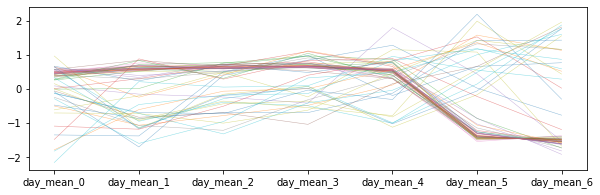

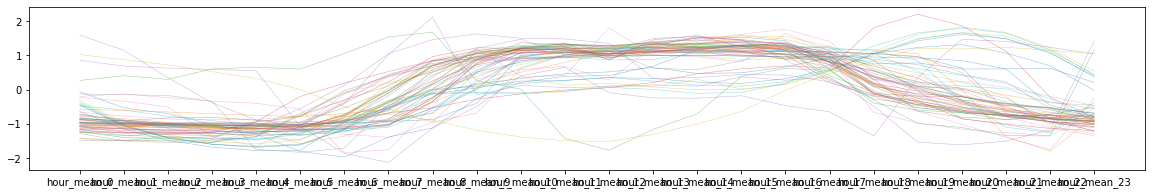

In [60]:
# visualization
fig = plt.figure(figsize = (10,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
    
fig = plt.figure(figsize = (20,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 8:32], alpha = 0.5, linewidth = 0.5)

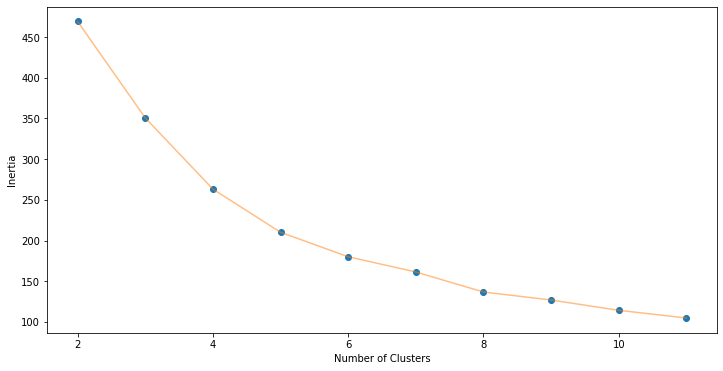

In [62]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], cl_df.iloc[:,1:])

### KMEANS

#### 4

In [63]:
model = KMeans(n_clusters = 4, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [64]:
cl_df['km_cluster'] = pred

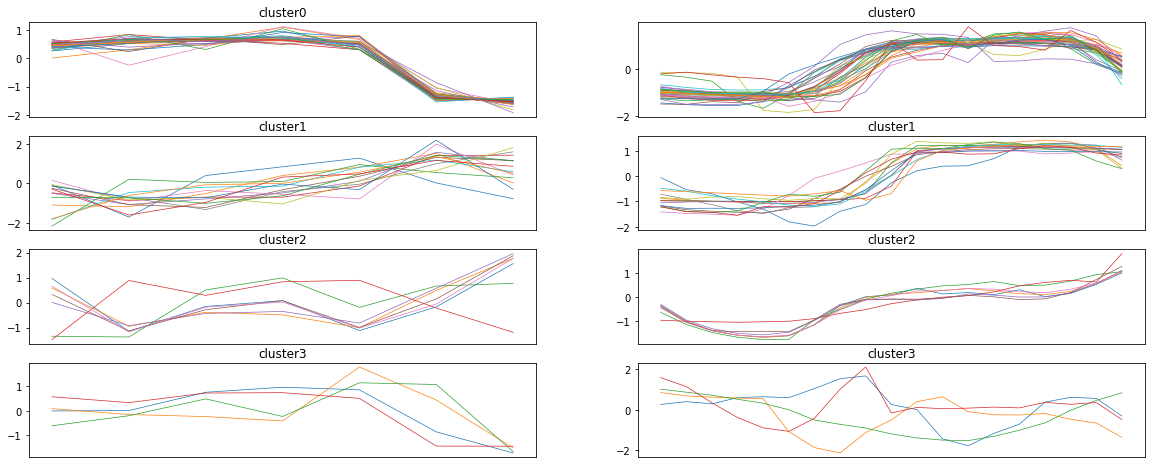

In [65]:
# visualizing result of kmeans clustering
n_c = len(np.unique(cl_df.km_cluster)) 

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = cl_df[cl_df.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [66]:
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

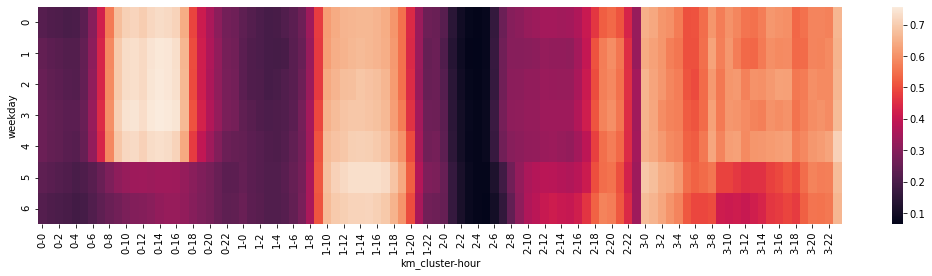

In [67]:
plt.figure(figsize=(18, 4))
sns.heatmap(train_cl.groupby(['km_cluster', 'hour', 'weekday'])['target'].mean().unstack().T)
plt.show()

In [68]:
train_cl.groupby(['km_cluster'])['num'].count().to_frame()/2040

num
km_cluster      
0           35.0
1           14.0
2            7.0
3            4.0

In [69]:
km_0 = list(train_cl.loc[train_cl.km_cluster == 0].num.unique())
km_1 = list(train_cl.loc[train_cl.km_cluster == 1].num.unique())
km_2 = list(train_cl.loc[train_cl.km_cluster == 2].num.unique())
km_3 = list(train_cl.loc[train_cl.km_cluster == 3].num.unique())

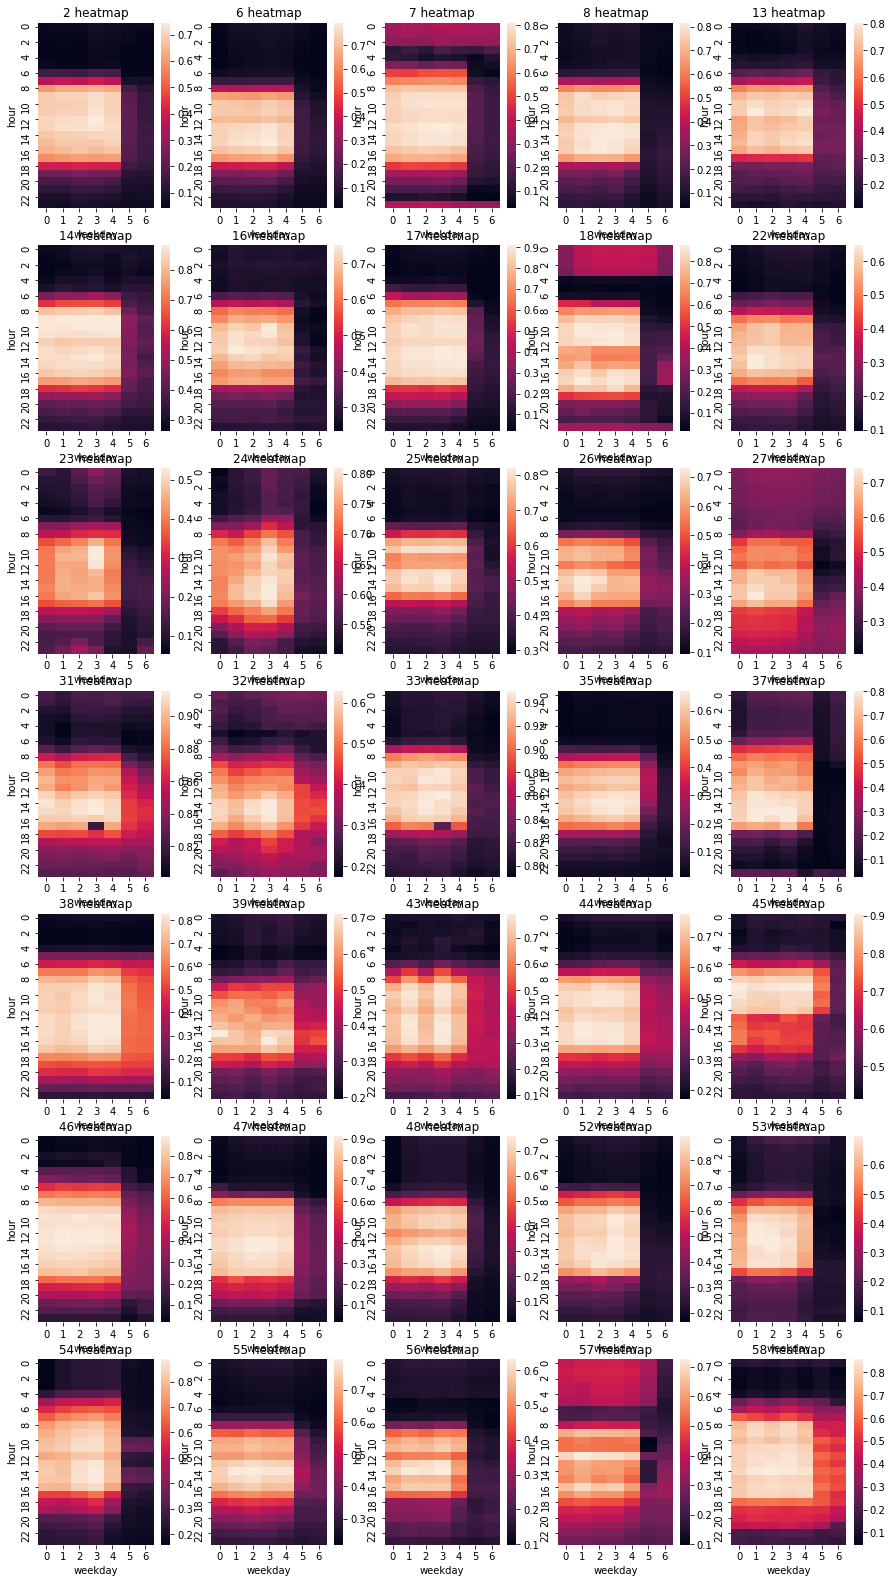

In [70]:
fig = plt.figure(figsize=(15, np.ceil(len(km_0)/5)*4))
for i, n in enumerate(km_0):
    plt.subplot(np.ceil(len(km_0)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

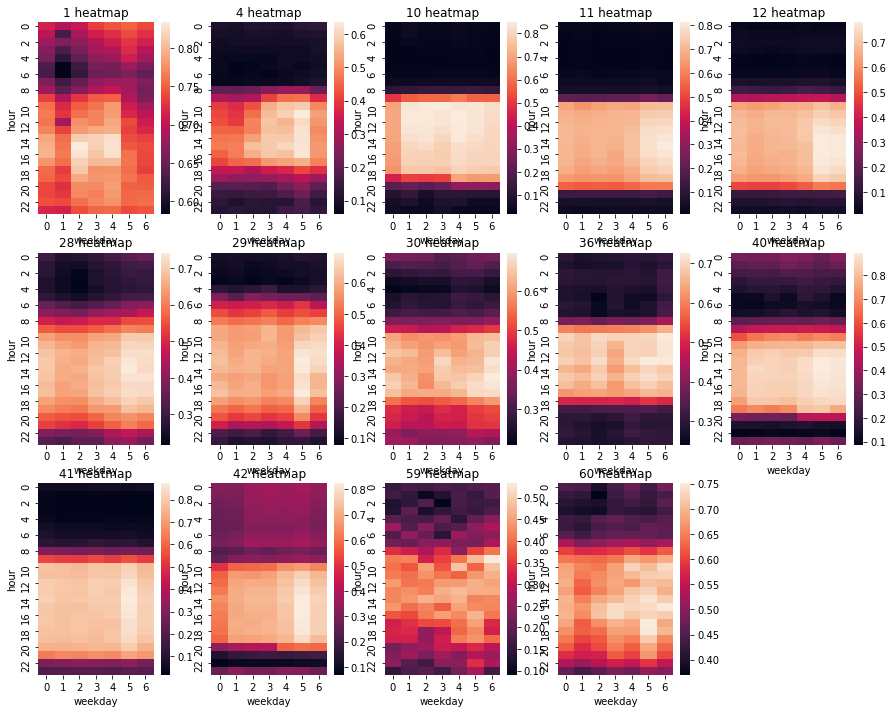

In [71]:
fig = plt.figure(figsize=(15, np.ceil(len(km_1)/5)*4))
for i, n in enumerate(km_1):
    plt.subplot(np.ceil(len(km_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

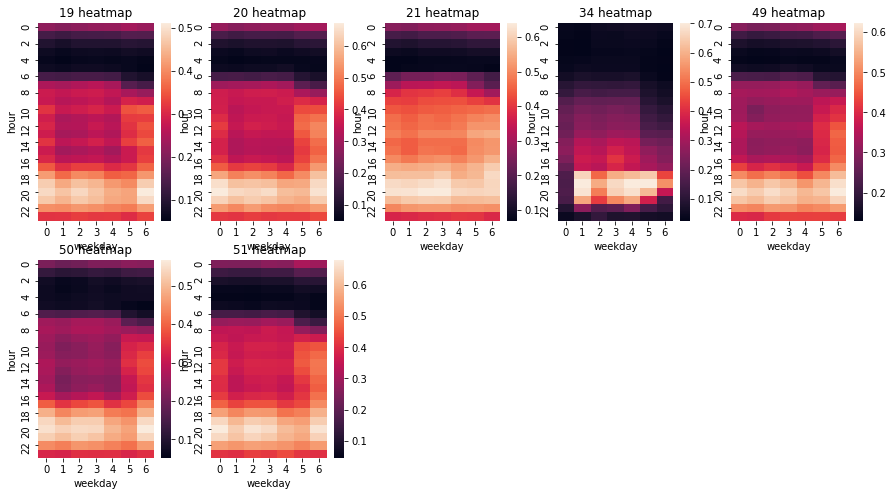

In [72]:
fig = plt.figure(figsize=(15, np.ceil(len(km_2)/5)*4))
for i, n in enumerate(km_2):
    plt.subplot(np.ceil(len(km_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

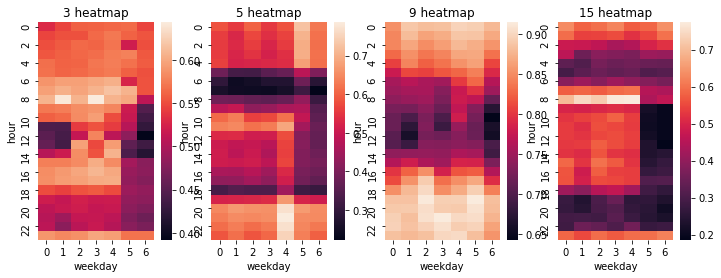

In [73]:
fig = plt.figure(figsize=(15, np.ceil(len(km_3)/5)*4))
for i, n in enumerate(km_3):
    plt.subplot(np.ceil(len(km_3)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

#### 5

In [74]:
model = KMeans(n_clusters = 5, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [75]:
cl_df['km_cluster'] = pred

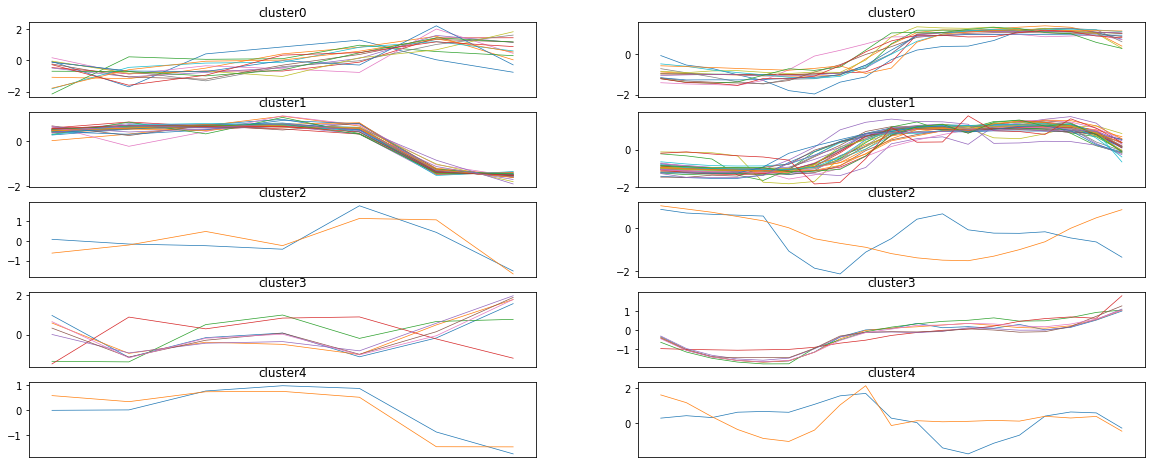

In [76]:
# visualizing result of kmeans clustering
n_c = len(np.unique(cl_df.km_cluster)) 

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = cl_df[cl_df.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [77]:
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

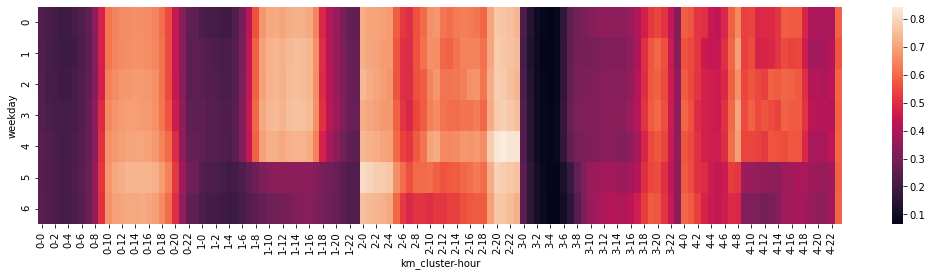

In [79]:
plt.figure(figsize=(18, 4))
sns.heatmap(train_cl.groupby(['km_cluster', 'hour', 'weekday'])['target'].mean().unstack().T)
plt.show()

In [80]:
train_cl.groupby(['km_cluster'])['num'].count().to_frame()/2040

num
km_cluster      
0           14.0
1           35.0
2            2.0
3            7.0
4            2.0

In [81]:
km_0 = list(train_cl.loc[train_cl.km_cluster == 0].num.unique())
km_1 = list(train_cl.loc[train_cl.km_cluster == 1].num.unique())
km_2 = list(train_cl.loc[train_cl.km_cluster == 2].num.unique())
km_3 = list(train_cl.loc[train_cl.km_cluster == 3].num.unique())
km_4 = list(train_cl.loc[train_cl.km_cluster == 4].num.unique())

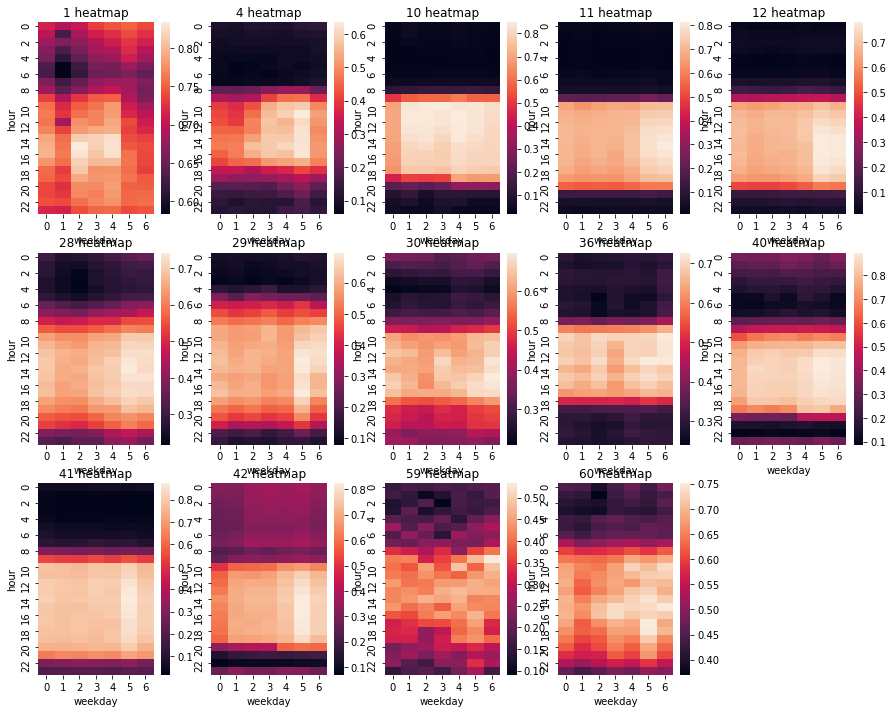

In [82]:
fig = plt.figure(figsize=(15, np.ceil(len(km_0)/5)*4))
for i, n in enumerate(km_0):
    plt.subplot(np.ceil(len(km_0)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

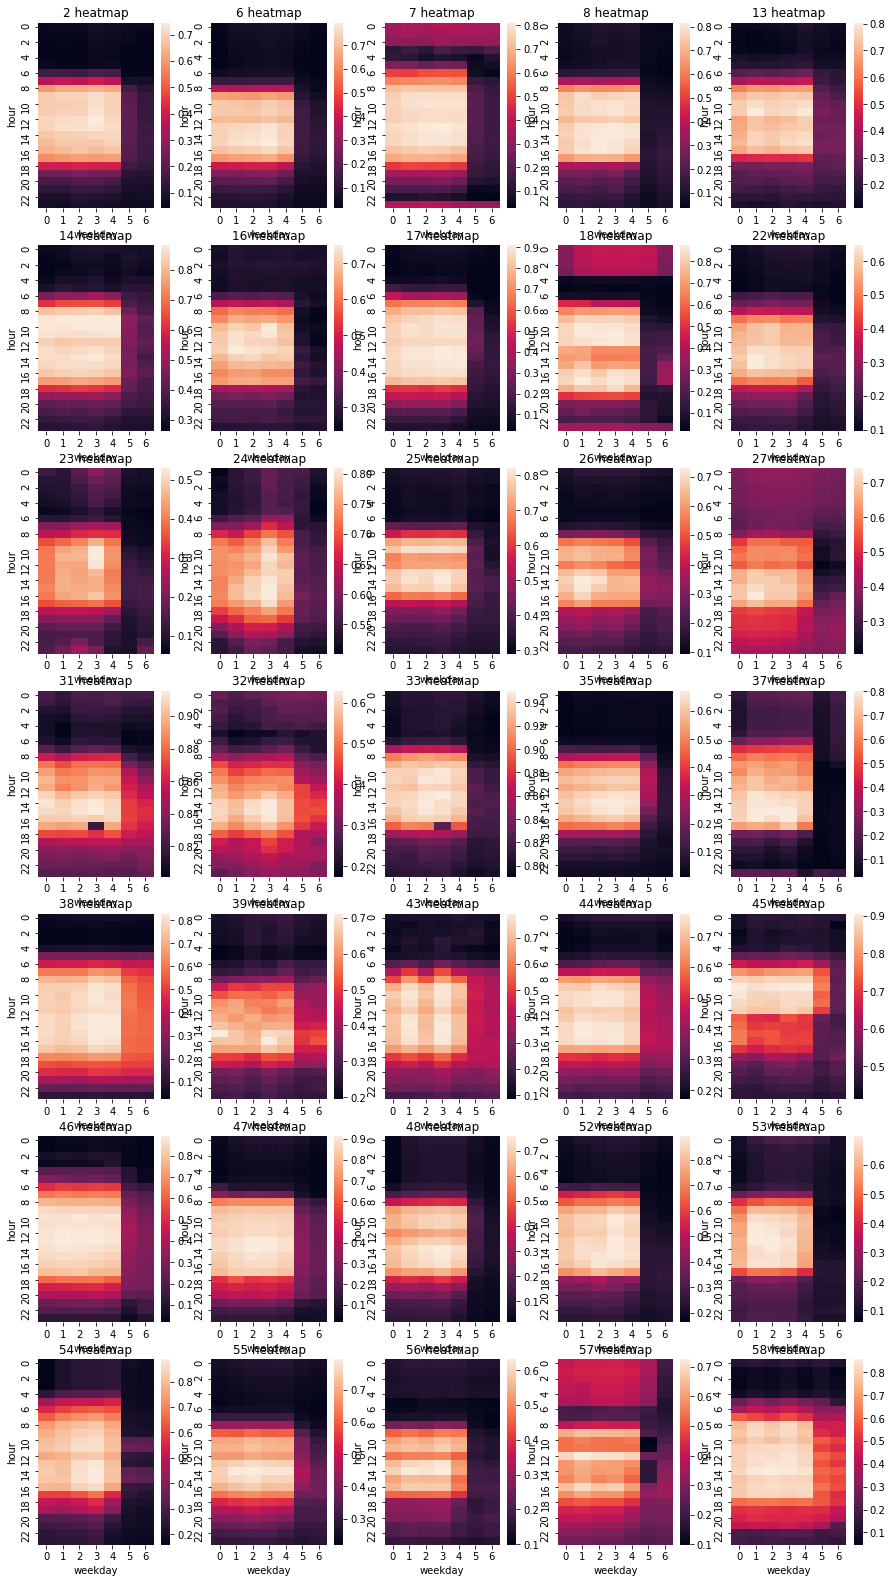

In [83]:
fig = plt.figure(figsize=(15, np.ceil(len(km_1)/5)*4))
for i, n in enumerate(km_1):
    plt.subplot(np.ceil(len(km_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

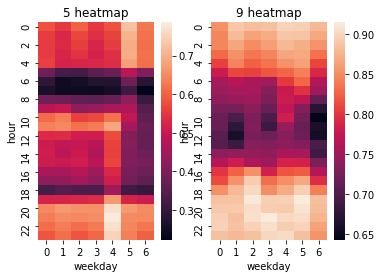

In [84]:
fig = plt.figure(figsize=(15, np.ceil(len(km_2)/5)*4))
for i, n in enumerate(km_2):
    plt.subplot(np.ceil(len(km_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

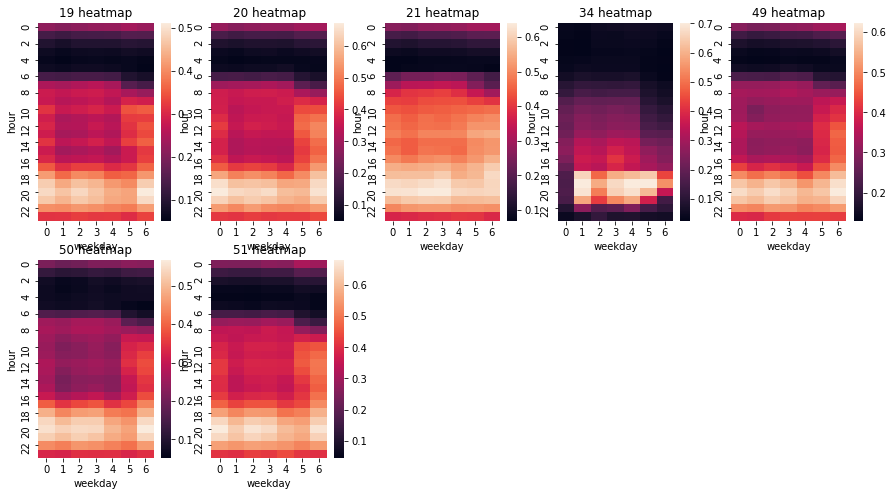

In [85]:
fig = plt.figure(figsize=(15, np.ceil(len(km_3)/5)*4))
for i, n in enumerate(km_3):
    plt.subplot(np.ceil(len(km_3)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

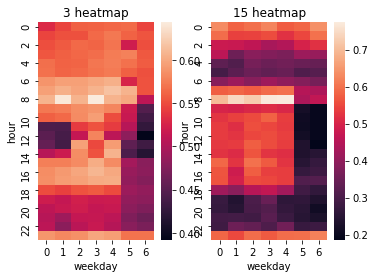

In [86]:
fig = plt.figure(figsize=(15, np.ceil(len(km_4)/5)*4))
for i, n in enumerate(km_4):
    plt.subplot(np.ceil(len(km_4)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

#### 6

In [87]:
model = KMeans(n_clusters = 6, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [88]:
cl_df['km_cluster'] = pred

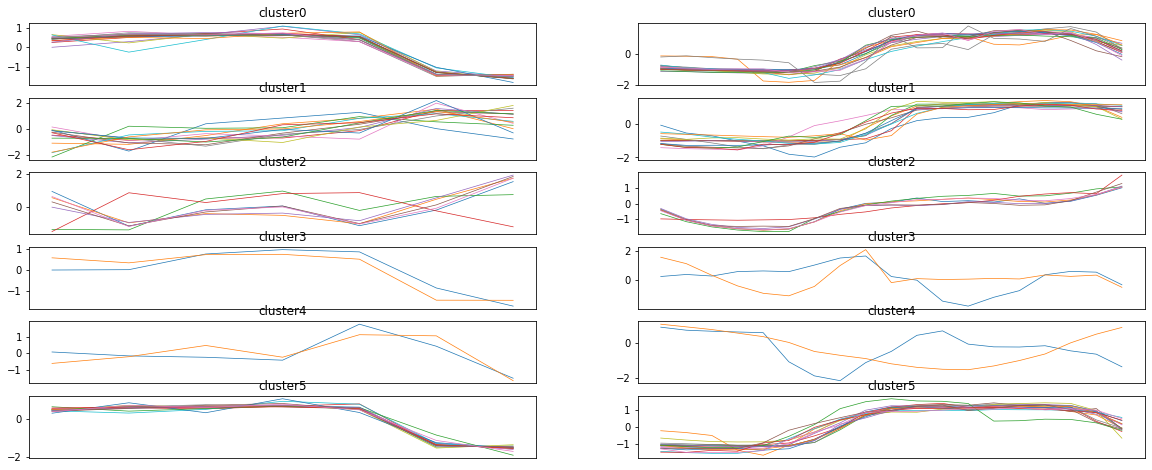

In [89]:
# visualizing result of kmeans clustering
n_c = len(np.unique(cl_df.km_cluster)) 

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = cl_df[cl_df.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [90]:
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

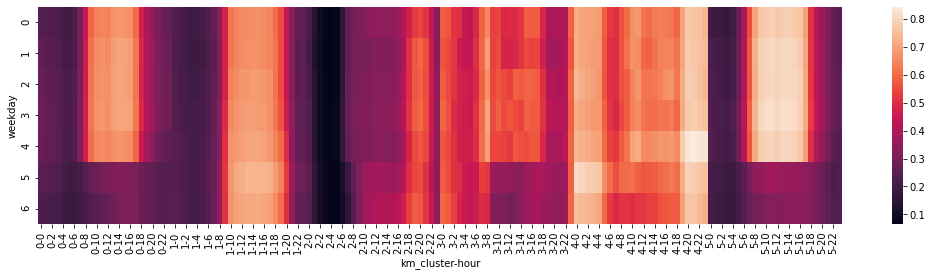

In [91]:
plt.figure(figsize=(18, 4))
sns.heatmap(train_cl.groupby(['km_cluster', 'hour', 'weekday'])['target'].mean().unstack().T)
plt.show()

In [92]:
train_cl.groupby(['km_cluster'])['num'].count().to_frame()/2040

num
km_cluster      
0           18.0
1           14.0
2            7.0
3            2.0
4            2.0
5           17.0

In [93]:
km_0 = list(train_cl.loc[train_cl.km_cluster == 0].num.unique())
km_1 = list(train_cl.loc[train_cl.km_cluster == 1].num.unique())
km_2 = list(train_cl.loc[train_cl.km_cluster == 2].num.unique())
km_3 = list(train_cl.loc[train_cl.km_cluster == 3].num.unique())
km_4 = list(train_cl.loc[train_cl.km_cluster == 4].num.unique())
km_5 = list(train_cl.loc[train_cl.km_cluster == 5].num.unique())

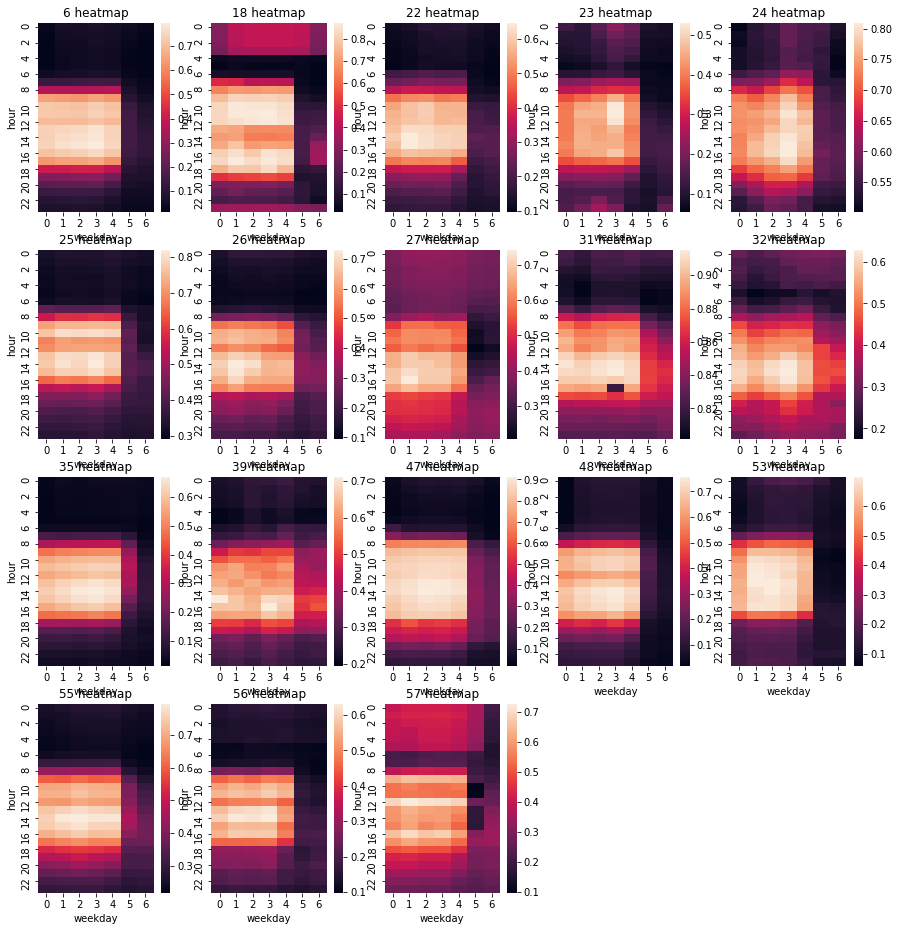

In [94]:
fig = plt.figure(figsize=(15, np.ceil(len(km_0)/5)*4))
for i, n in enumerate(km_0):
    plt.subplot(np.ceil(len(km_0)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

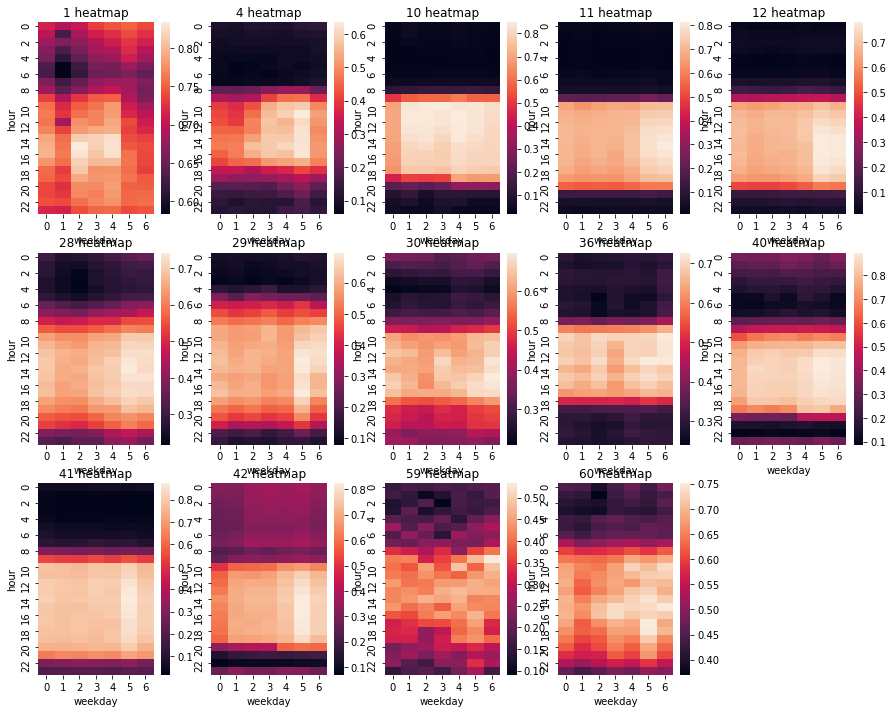

In [95]:
fig = plt.figure(figsize=(15, np.ceil(len(km_1)/5)*4))
for i, n in enumerate(km_1):
    plt.subplot(np.ceil(len(km_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

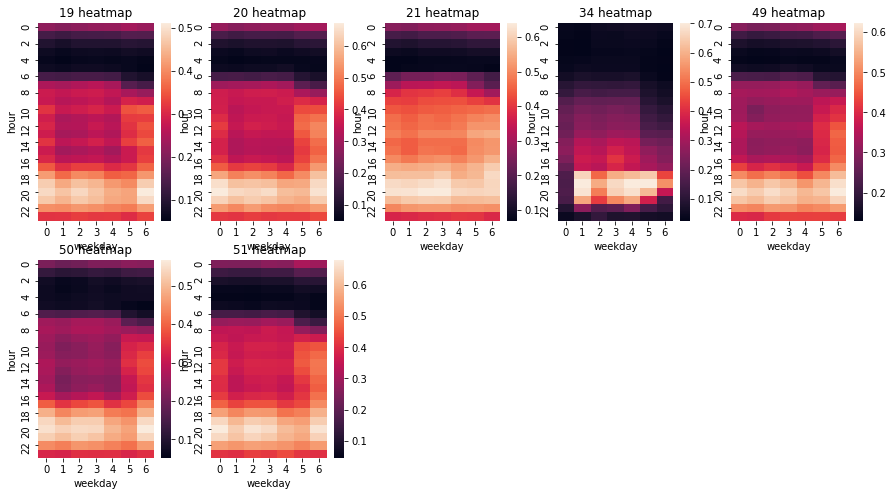

In [96]:
fig = plt.figure(figsize=(15, np.ceil(len(km_2)/5)*4))
for i, n in enumerate(km_2):
    plt.subplot(np.ceil(len(km_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

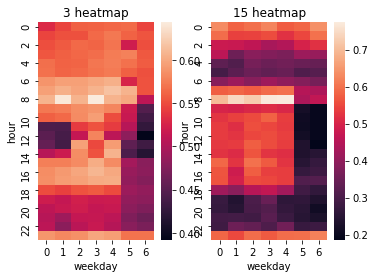

In [97]:
fig = plt.figure(figsize=(15, np.ceil(len(km_3)/5)*4))
for i, n in enumerate(km_3):
    plt.subplot(np.ceil(len(km_3)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

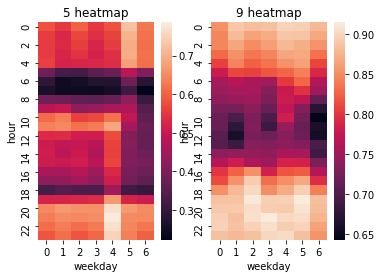

In [98]:
fig = plt.figure(figsize=(15, np.ceil(len(km_4)/5)*4))
for i, n in enumerate(km_4):
    plt.subplot(np.ceil(len(km_4)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

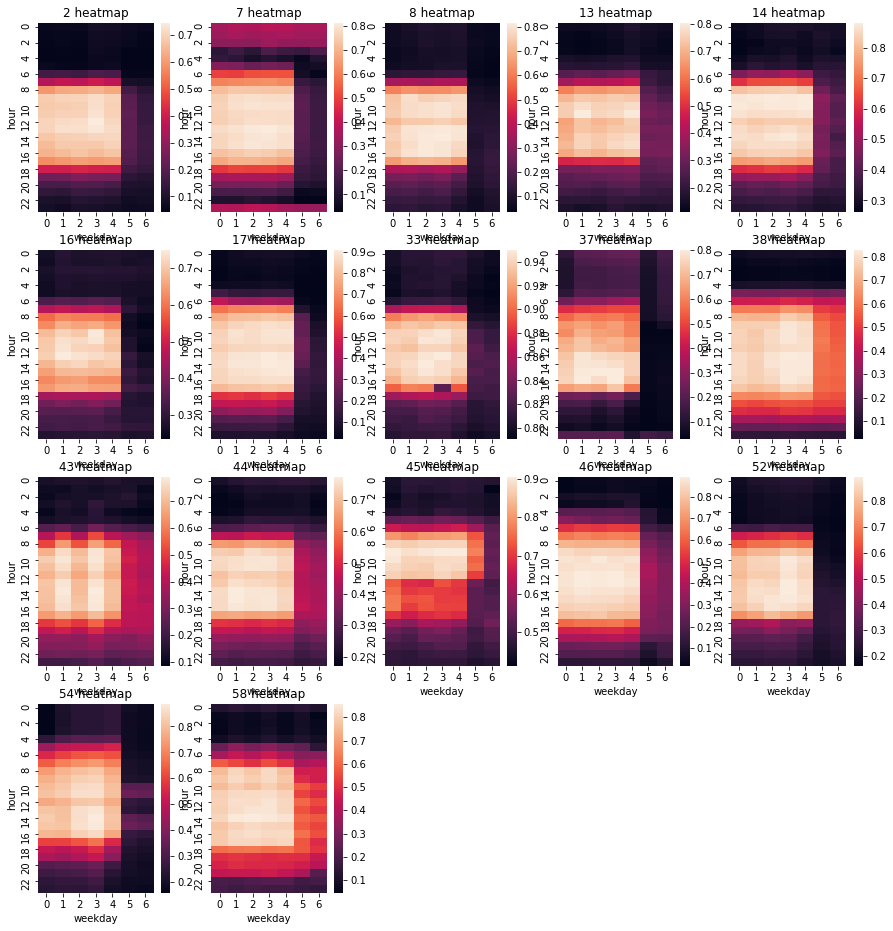

In [99]:
fig = plt.figure(figsize=(15, np.ceil(len(km_5)/5)*4))
for i, n in enumerate(km_5):
    plt.subplot(np.ceil(len(km_5)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

Kmeans 같은 경우 4개의 군집이 가장 합리적이다.

### DBSCAN

In [173]:
from sklearn.neighbors import NearestNeighbors

In [183]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(cl_df.iloc[:, 1:])
distances, indices = nbrs.kneighbors(cl_df.iloc[:, 1:])

In [184]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

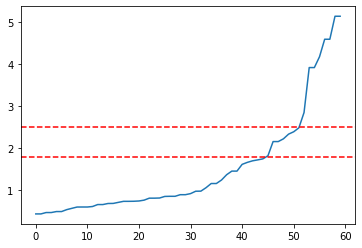

In [193]:
plt.plot(distances)
plt.axhline(y = 1.8, color = 'r', linestyle = '--')
plt.axhline(y = 2.5, color = 'r', linestyle = '--')
plt.show()

#### eps=1.8

In [194]:
from collections import Counter

In [195]:
model = DBSCAN(eps=1.8, min_samples=3,
              metric='euclidean')
model.fit(cl_df.iloc[:, 1:])
model.labels_

array([-1,  0, -1, -1, -1,  1,  0,  0, -1,  4,  2,  2,  0,  0, -1,  0,  0,
       -1,  3,  3, -1,  1,  1,  1,  1,  1,  1,  2, -1,  2,  1,  1,  0, -1,
        1, -1,  0,  0,  1,  4, -1,  4,  0,  0, -1,  0,  1,  1,  3,  3,  3,
        0,  1,  0,  1,  1, -1,  0, -1,  2], dtype=int64)

In [196]:
Counter(model.labels_)

Counter({-1: 15, 0: 16, 1: 16, 4: 3, 2: 5, 3: 5})

In [197]:
cl_df['db_cluster'] = model.labels_

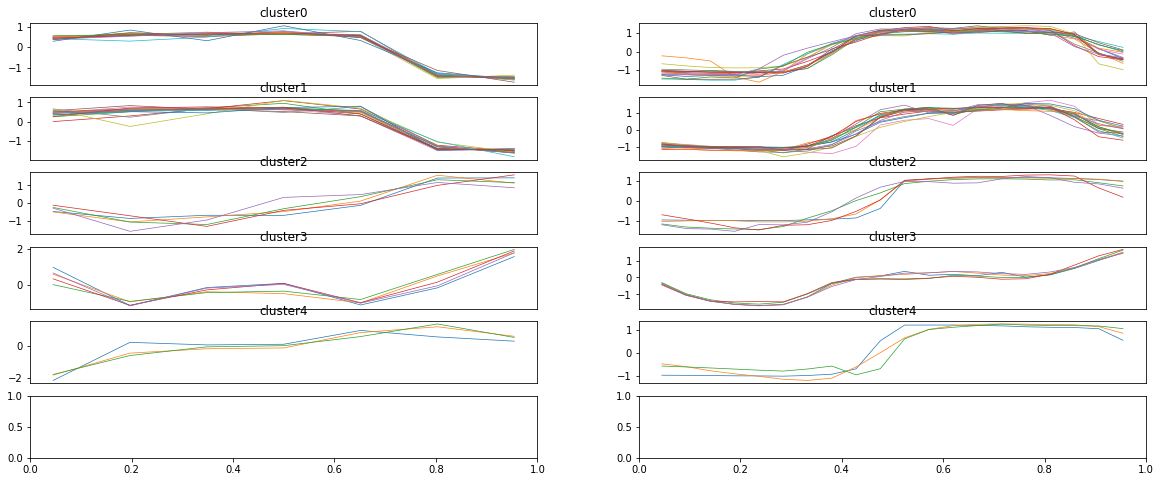

In [198]:
# visualizing result of kmeans clustering
n_c = len(np.unique(cl_df.db_cluster)) 

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = cl_df[cl_df.db_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [199]:
train_cl = pd.merge(train, cl_df[['num', 'db_cluster']], how='left', on='num')

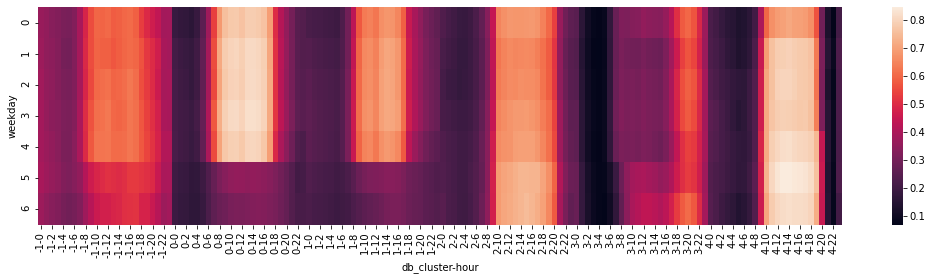

In [200]:
plt.figure(figsize=(18, 4))
sns.heatmap(train_cl.groupby(['db_cluster', 'hour', 'weekday'])['target'].mean().unstack().T)
plt.show()

In [201]:
train_cl.groupby(['db_cluster'])['num'].count().to_frame()/2040

num
db_cluster      
-1          15.0
 0          16.0
 1          16.0
 2           5.0
 3           5.0
 4           3.0

In [202]:
sorted(train_cl.db_cluster.unique())

[-1, 0, 1, 2, 3, 4]

In [203]:
for i in sorted(train_cl.db_cluster.unique()):

    globals()['db_{}'.format(i)] = list(train_cl.loc[train_cl.db_cluster == i].num.unique())

In [204]:
db_99 = list(train_cl.loc[train_cl.db_cluster == -1].num.unique())

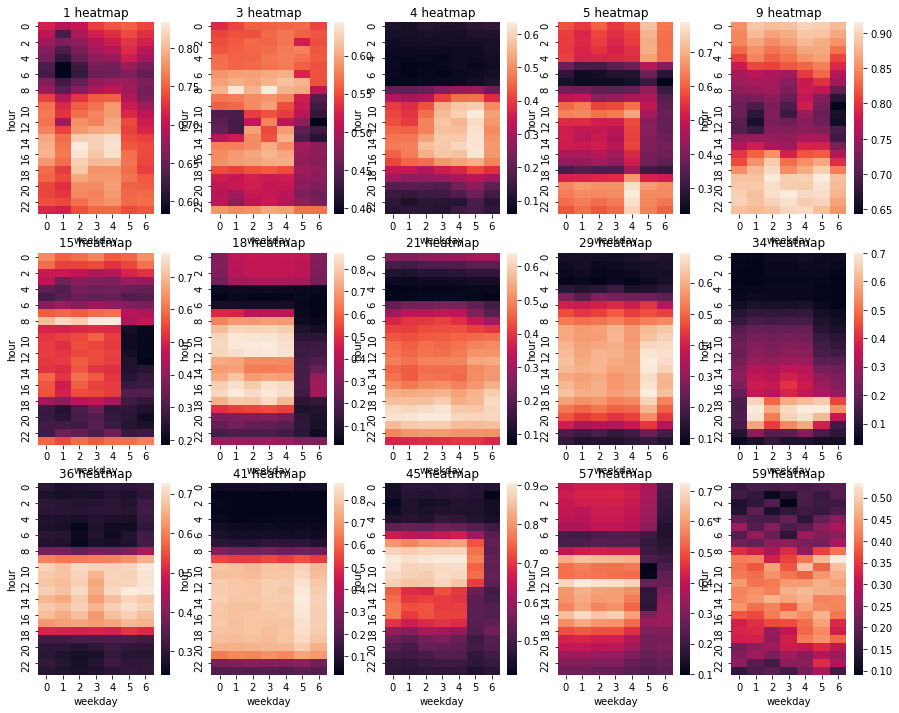

In [205]:
fig = plt.figure(figsize=(15, np.ceil(len(db_99)/5)*4))
for i, n in enumerate(db_99):
    plt.subplot(np.ceil(len(db_99)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

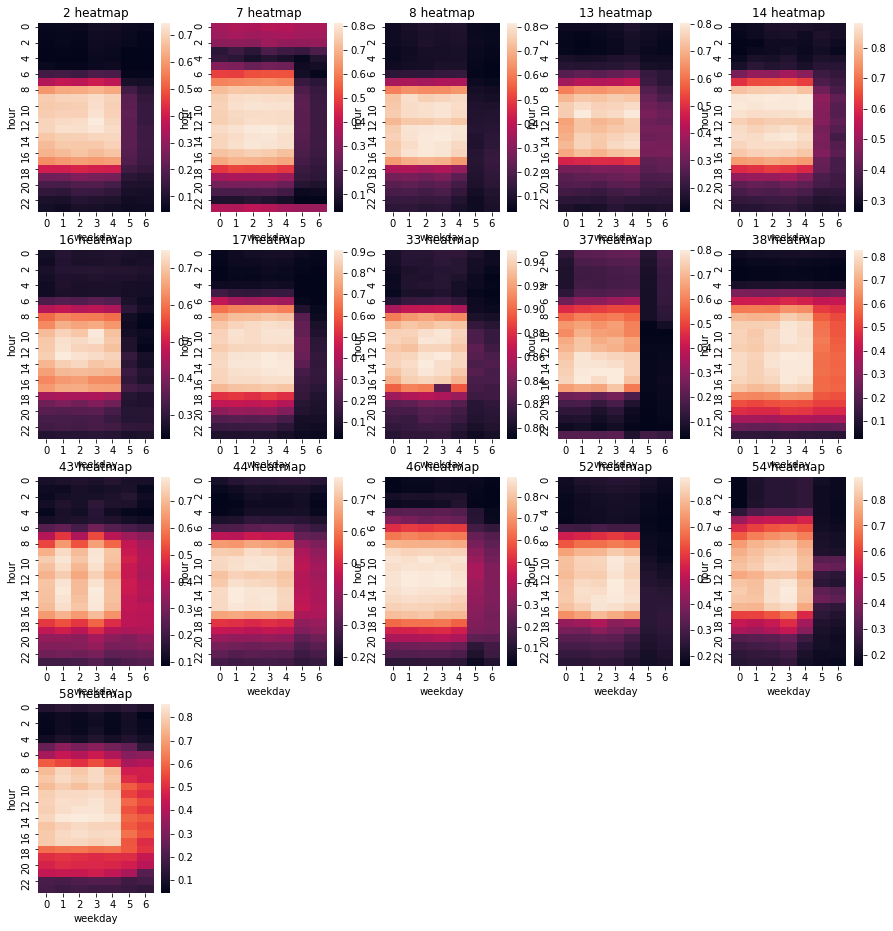

In [206]:
fig = plt.figure(figsize=(15, np.ceil(len(db_0)/5)*4))
for i, n in enumerate(db_0):
    plt.subplot(np.ceil(len(db_0)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

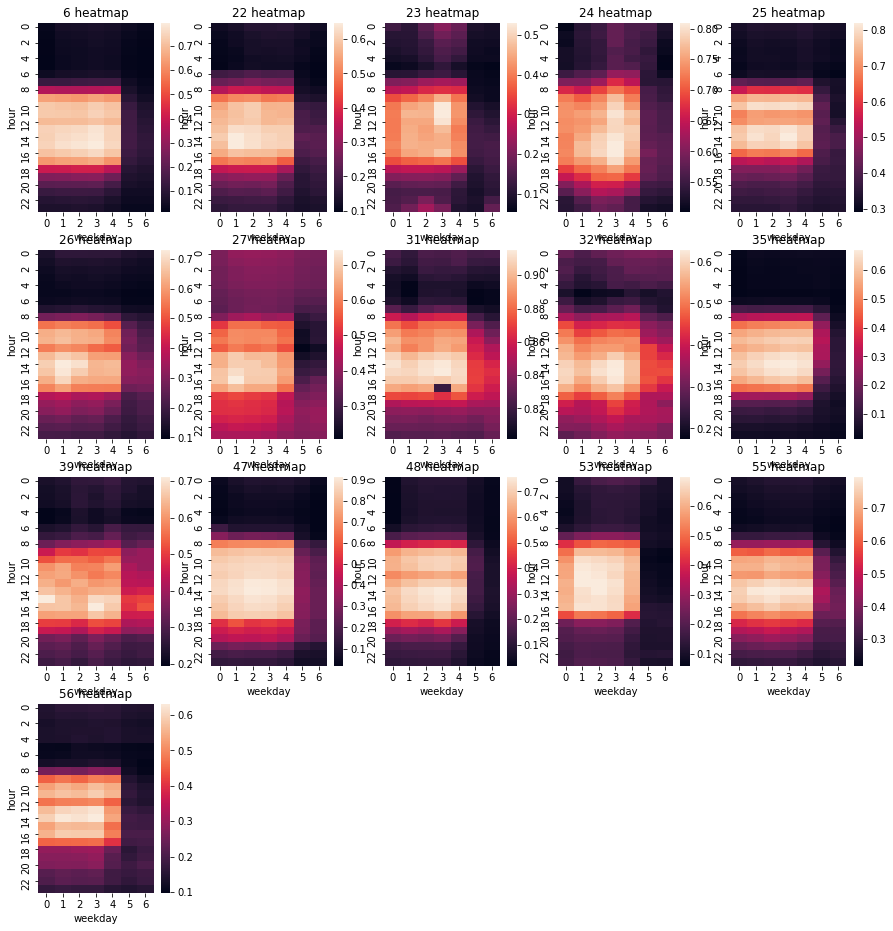

In [207]:
fig = plt.figure(figsize=(15, np.ceil(len(db_1)/5)*4))
for i, n in enumerate(db_1):
    plt.subplot(np.ceil(len(db_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

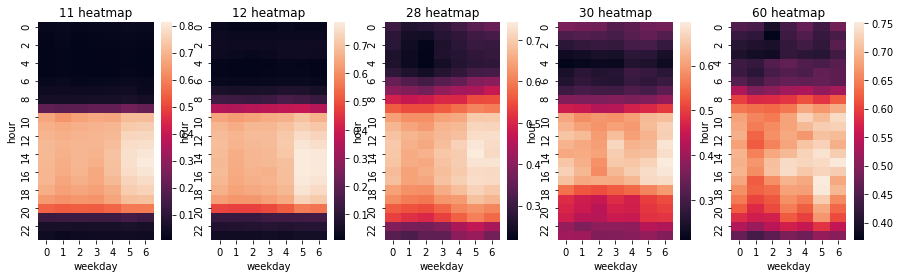

In [208]:
fig = plt.figure(figsize=(15, np.ceil(len(db_2)/5)*4))
for i, n in enumerate(db_2):
    plt.subplot(np.ceil(len(db_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

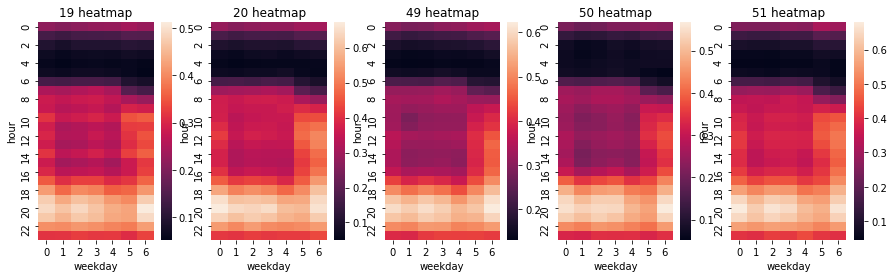

In [209]:
fig = plt.figure(figsize=(15, np.ceil(len(db_3)/5)*4))
for i, n in enumerate(db_3):
    plt.subplot(np.ceil(len(db_3)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

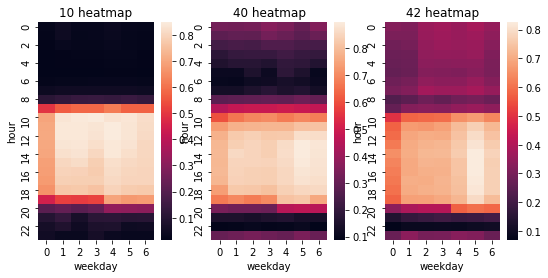

In [210]:
fig = plt.figure(figsize=(15, np.ceil(len(db_4)/5)*4))
for i, n in enumerate(db_4):
    plt.subplot(np.ceil(len(db_4)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

#### eps=2.5

In [211]:
from collections import Counter

In [212]:
model = DBSCAN(eps=2.5, min_samples=3,
              metric='euclidean')
model.fit(cl_df.iloc[:, 1:])
model.labels_

array([-1,  0, -1,  5, -1,  1,  0,  0, -1,  2,  3,  3,  0,  0, -1,  0,  0,
       -1,  4,  4, -1,  1,  1,  1,  1,  1,  1,  3, -1,  3,  1,  1,  0, -1,
        1,  5,  0,  0,  1,  2, -1,  2,  0,  0,  0,  0,  1,  1,  4,  4,  4,
        0,  1,  0,  1,  1, -1,  0,  5,  3], dtype=int64)

In [213]:
Counter(model.labels_)

Counter({-1: 11, 0: 17, 5: 3, 1: 16, 2: 3, 3: 5, 4: 5})

In [214]:
cl_df['db_cluster'] = model.labels_

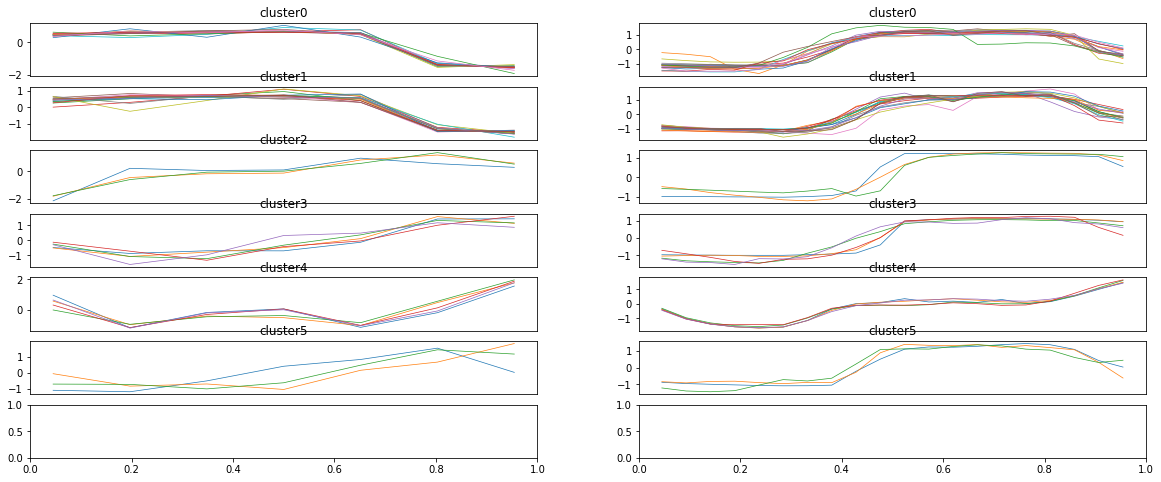

In [215]:
# visualizing result of kmeans clustering
n_c = len(np.unique(cl_df.db_cluster)) 

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = cl_df[cl_df.db_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [216]:
train_cl = pd.merge(train, cl_df[['num', 'db_cluster']], how='left', on='num')

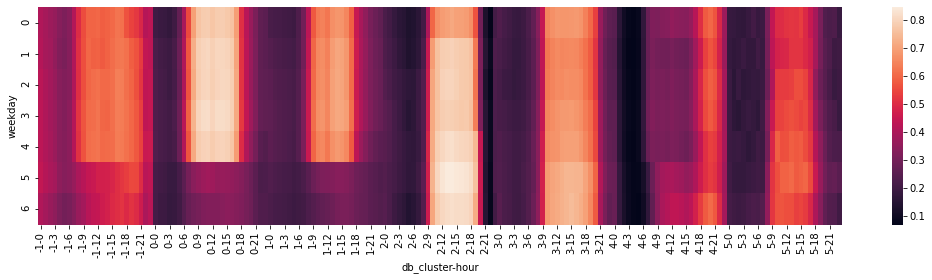

In [217]:
plt.figure(figsize=(18, 4))
sns.heatmap(train_cl.groupby(['db_cluster', 'hour', 'weekday'])['target'].mean().unstack().T)
plt.show()

In [218]:
train_cl.groupby(['db_cluster'])['num'].count().to_frame()/2040

num
db_cluster      
-1          11.0
 0          17.0
 1          16.0
 2           3.0
 3           5.0
 4           5.0
 5           3.0

In [219]:
sorted(train_cl.db_cluster.unique())

[-1, 0, 1, 2, 3, 4, 5]

In [220]:
for i in sorted(train_cl.db_cluster.unique()):

    globals()['db_{}'.format(i)] = list(train_cl.loc[train_cl.db_cluster == i].num.unique())

In [221]:
db_99 = list(train_cl.loc[train_cl.db_cluster == -1].num.unique())

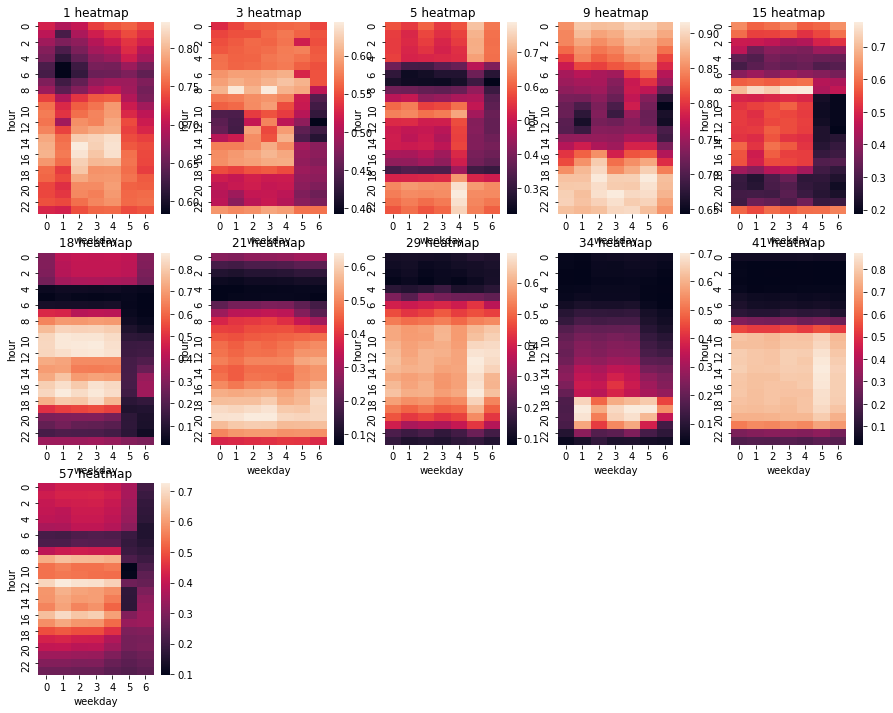

In [222]:
fig = plt.figure(figsize=(15, np.ceil(len(db_99)/5)*4))
for i, n in enumerate(db_99):
    plt.subplot(np.ceil(len(db_99)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

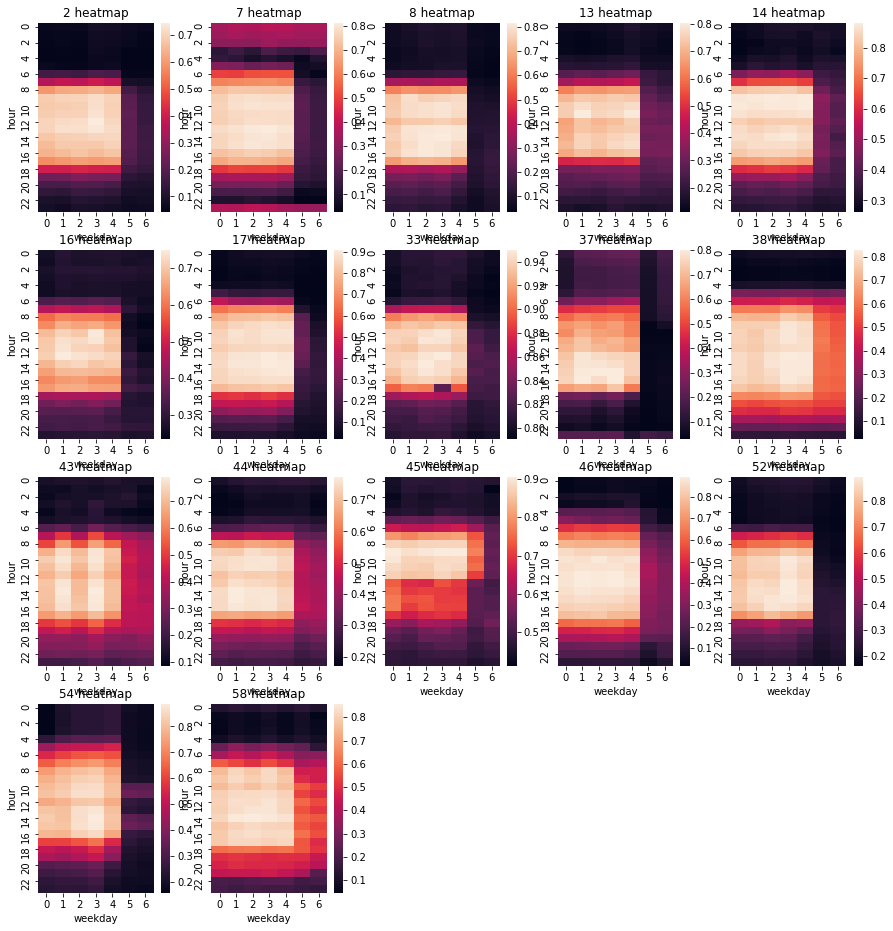

In [223]:
fig = plt.figure(figsize=(15, np.ceil(len(db_0)/5)*4))
for i, n in enumerate(db_0):
    plt.subplot(np.ceil(len(db_0)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

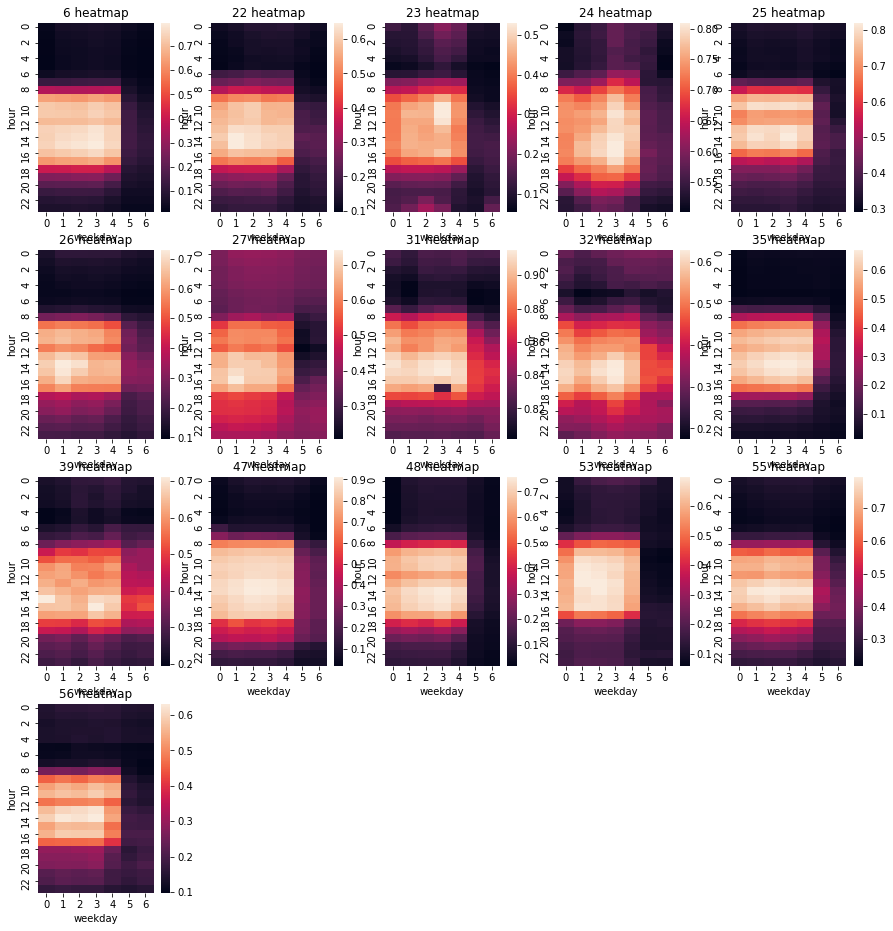

In [224]:
fig = plt.figure(figsize=(15, np.ceil(len(db_1)/5)*4))
for i, n in enumerate(db_1):
    plt.subplot(np.ceil(len(db_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

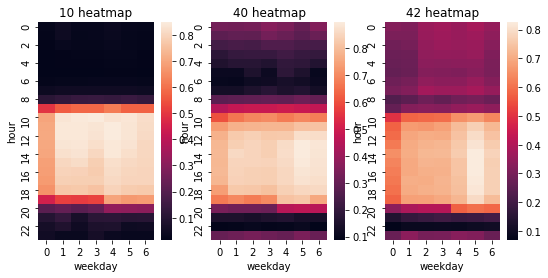

In [225]:
fig = plt.figure(figsize=(15, np.ceil(len(db_2)/5)*4))
for i, n in enumerate(db_2):
    plt.subplot(np.ceil(len(db_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

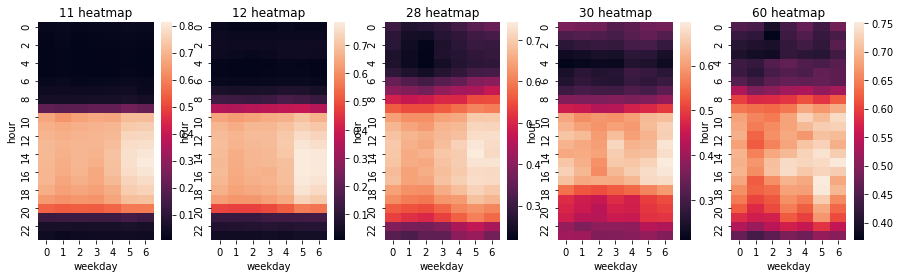

In [226]:
fig = plt.figure(figsize=(15, np.ceil(len(db_3)/5)*4))
for i, n in enumerate(db_3):
    plt.subplot(np.ceil(len(db_3)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

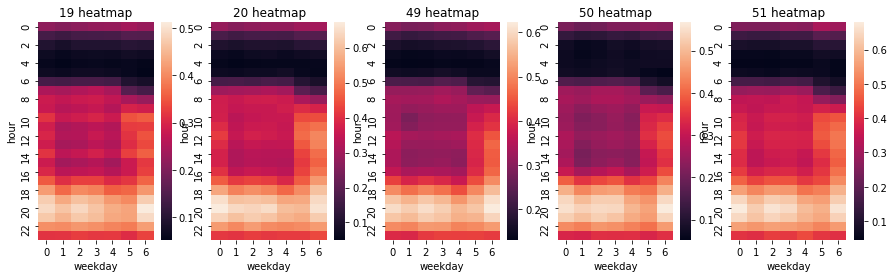

In [227]:
fig = plt.figure(figsize=(15, np.ceil(len(db_4)/5)*4))
for i, n in enumerate(db_4):
    plt.subplot(np.ceil(len(db_4)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

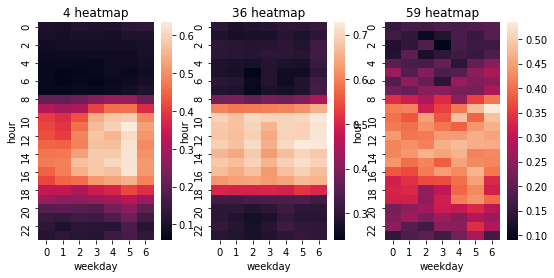

In [228]:
fig = plt.figure(figsize=(15, np.ceil(len(db_5)/5)*4))
for i, n in enumerate(db_5):
    plt.subplot(np.ceil(len(db_5)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

#### eps=4

In [110]:
from collections import Counter

In [149]:
model = DBSCAN(eps=4, min_samples=3,
              metric='euclidean')
model.fit(cl_df.iloc[:, 1:])
model.labels_

array([-1,  0, -1,  1, -1,  2,  0,  0, -1,  1,  1,  1,  0,  0, -1,  0,  0,
        2,  3,  3, -1,  2,  2,  2,  2,  2,  2,  1,  1,  1,  2,  2,  0, -1,
        2,  1,  0,  0,  2,  1,  1,  1,  0,  0,  0,  0,  2,  2,  3,  3,  3,
        0,  2,  0,  2,  2,  2,  0,  1,  1], dtype=int64)

In [150]:
Counter(model.labels_)

Counter({-1: 7, 0: 17, 1: 13, 2: 18, 3: 5})

In [151]:
cl_df['db_cluster'] = model.labels_

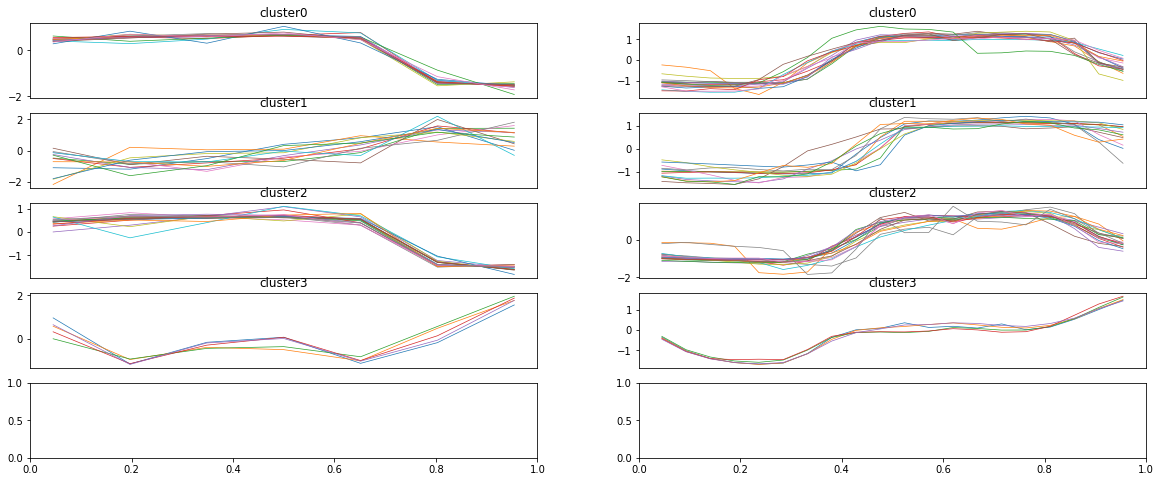

In [152]:
# visualizing result of kmeans clustering
n_c = len(np.unique(cl_df.db_cluster)) 

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = cl_df[cl_df.db_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [153]:
train_cl = pd.merge(train, cl_df[['num', 'db_cluster']], how='left', on='num')

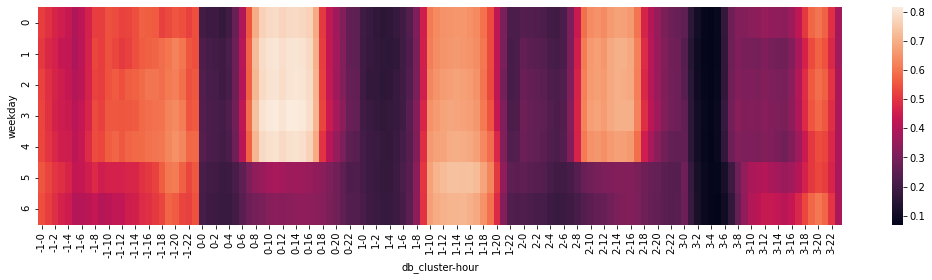

In [154]:
plt.figure(figsize=(18, 4))
sns.heatmap(train_cl.groupby(['db_cluster', 'hour', 'weekday'])['target'].mean().unstack().T)
plt.show()

In [155]:
train_cl.groupby(['db_cluster'])['num'].count().to_frame()/2040

num
db_cluster      
-1           7.0
 0          17.0
 1          13.0
 2          18.0
 3           5.0

In [156]:
sorted(train_cl.db_cluster.unique())

[-1, 0, 1, 2, 3]

In [157]:
for i in sorted(train_cl.db_cluster.unique()):

    globals()['db_{}'.format(i)] = list(train_cl.loc[train_cl.db_cluster == i].num.unique())

In [158]:
db_99 = list(train_cl.loc[train_cl.db_cluster == -1].num.unique())

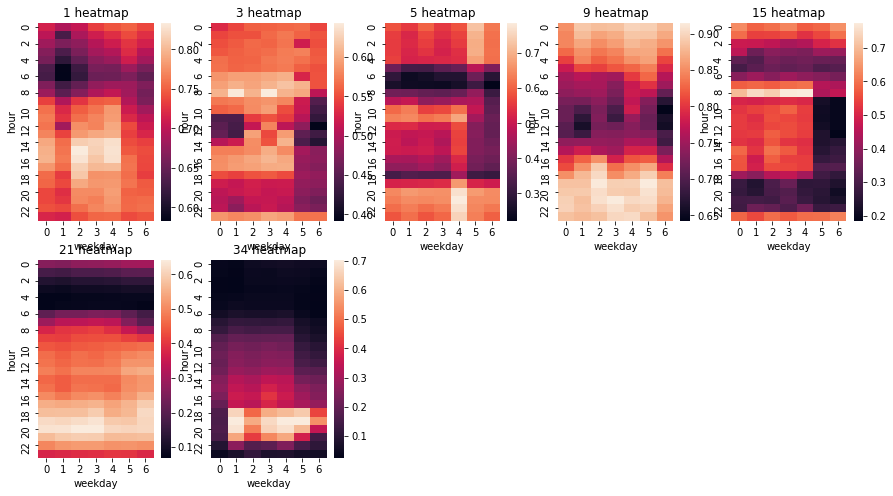

In [159]:
fig = plt.figure(figsize=(15, np.ceil(len(db_99)/5)*4))
for i, n in enumerate(db_99):
    plt.subplot(np.ceil(len(db_99)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

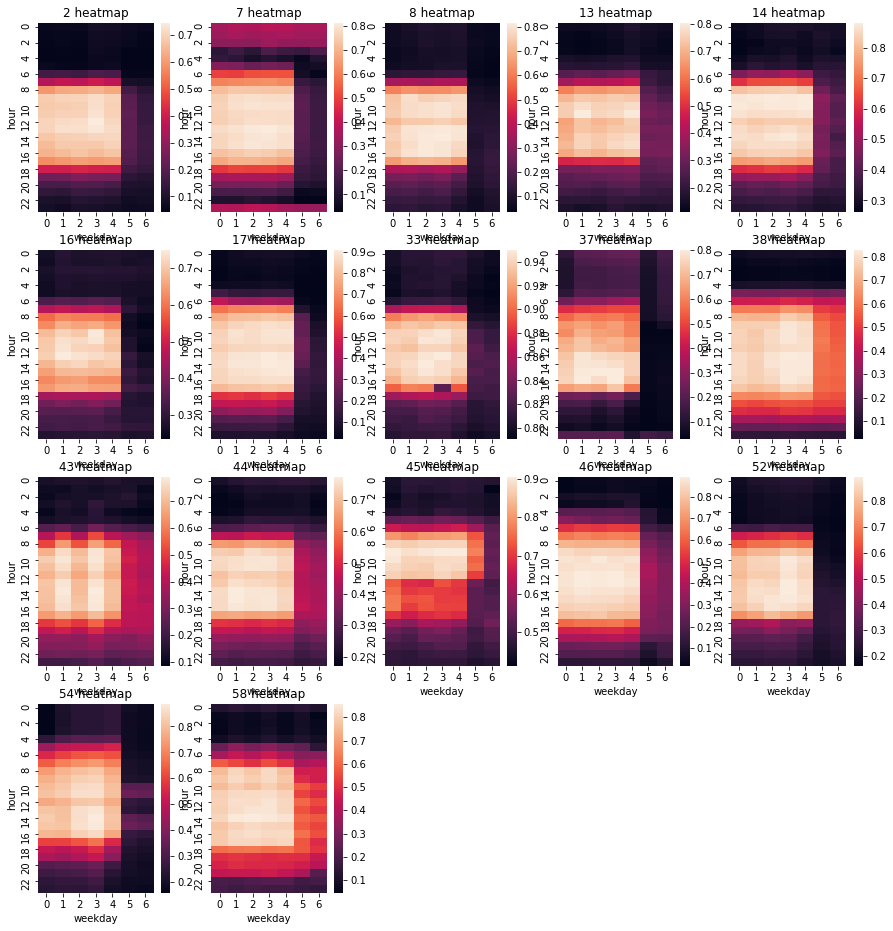

In [160]:
fig = plt.figure(figsize=(15, np.ceil(len(db_0)/5)*4))
for i, n in enumerate(db_0):
    plt.subplot(np.ceil(len(db_0)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

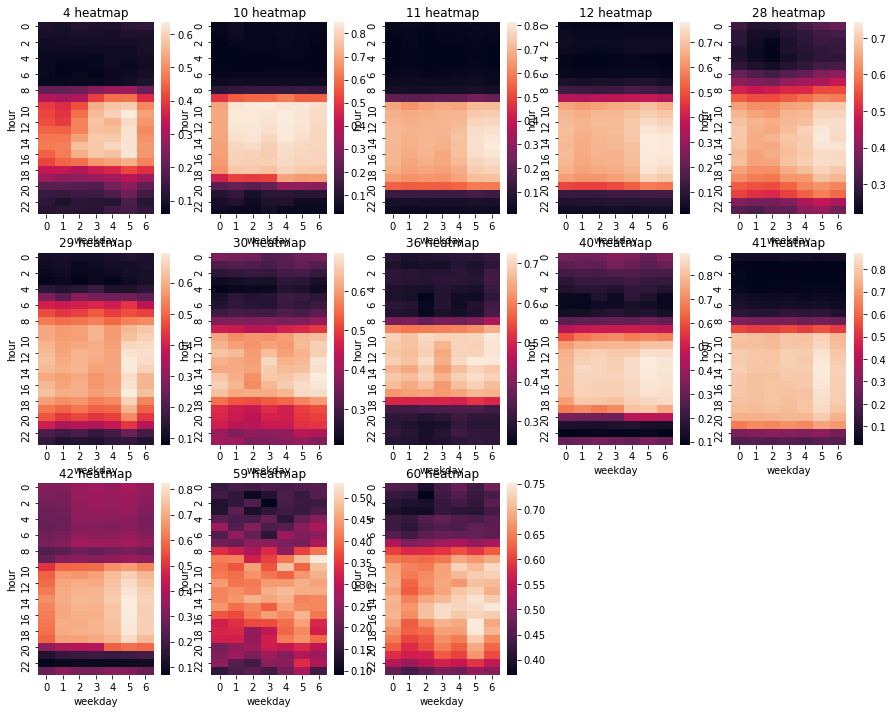

In [161]:
fig = plt.figure(figsize=(15, np.ceil(len(db_1)/5)*4))
for i, n in enumerate(db_1):
    plt.subplot(np.ceil(len(db_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

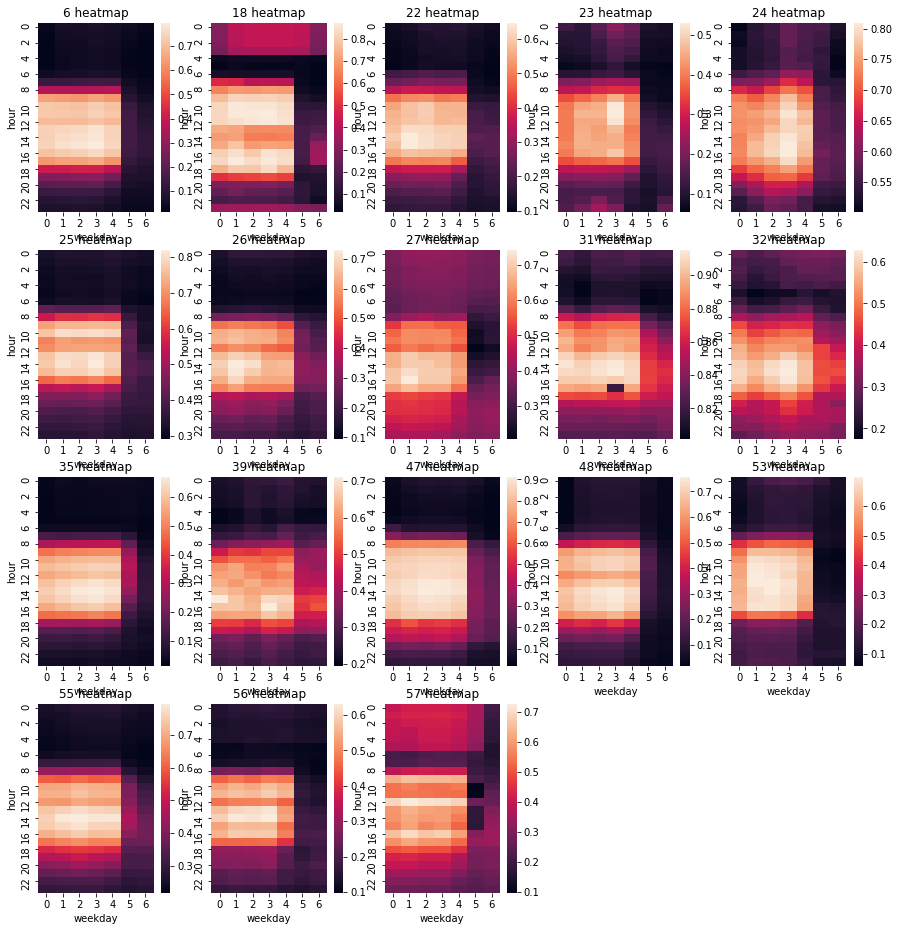

In [162]:
fig = plt.figure(figsize=(15, np.ceil(len(db_2)/5)*4))
for i, n in enumerate(db_2):
    plt.subplot(np.ceil(len(db_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

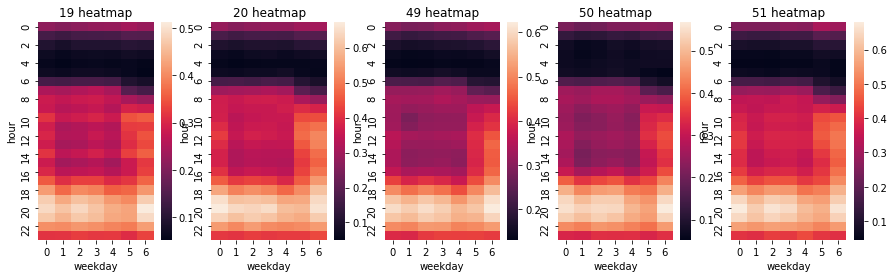

In [163]:
fig = plt.figure(figsize=(15, np.ceil(len(db_3)/5)*4))
for i, n in enumerate(db_3):
    plt.subplot(np.ceil(len(db_3)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

#### eps=5

In [165]:
from collections import Counter

In [170]:
model = DBSCAN(eps=3.5, min_samples=3,
              metric='euclidean')
model.fit(cl_df.iloc[:, 1:])
model.labels_

array([-1,  0, -1,  1, -1,  2,  0,  0, -1,  1,  1,  1,  0,  0, -1,  0,  0,
        2,  3,  3, -1,  2,  2,  2,  2,  2,  2,  1,  1,  1,  2,  2,  0, -1,
        2,  1,  0,  0,  2,  1,  1,  1,  0,  0,  0,  0,  2,  2,  3,  3,  3,
        0,  2,  0,  2,  2,  2,  0,  1,  1], dtype=int64)

In [171]:
Counter(model.labels_)

Counter({-1: 7, 0: 17, 1: 13, 2: 18, 3: 5})

In [151]:
cl_df['db_cluster'] = model.labels_

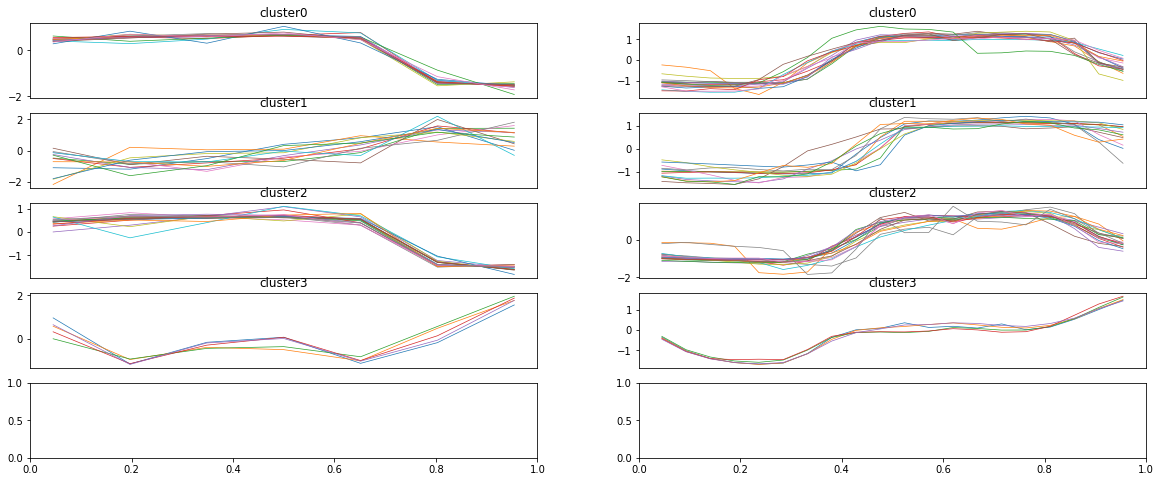

In [152]:
# visualizing result of kmeans clustering
n_c = len(np.unique(cl_df.db_cluster)) 

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = cl_df[cl_df.db_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [153]:
train_cl = pd.merge(train, cl_df[['num', 'db_cluster']], how='left', on='num')

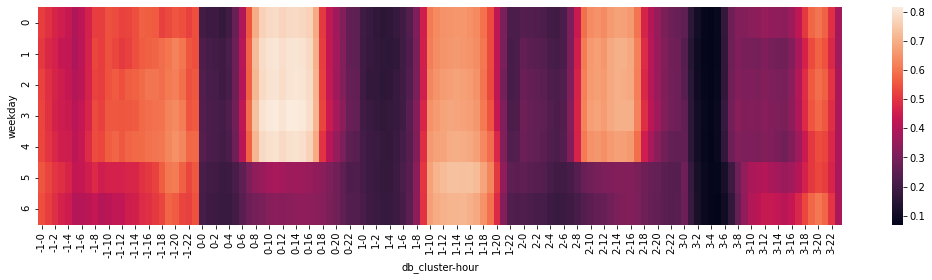

In [154]:
plt.figure(figsize=(18, 4))
sns.heatmap(train_cl.groupby(['db_cluster', 'hour', 'weekday'])['target'].mean().unstack().T)
plt.show()

In [155]:
train_cl.groupby(['db_cluster'])['num'].count().to_frame()/2040

num
db_cluster      
-1           7.0
 0          17.0
 1          13.0
 2          18.0
 3           5.0

In [156]:
sorted(train_cl.db_cluster.unique())

[-1, 0, 1, 2, 3]

In [157]:
for i in sorted(train_cl.db_cluster.unique()):

    globals()['db_{}'.format(i)] = list(train_cl.loc[train_cl.db_cluster == i].num.unique())

In [158]:
db_99 = list(train_cl.loc[train_cl.db_cluster == -1].num.unique())

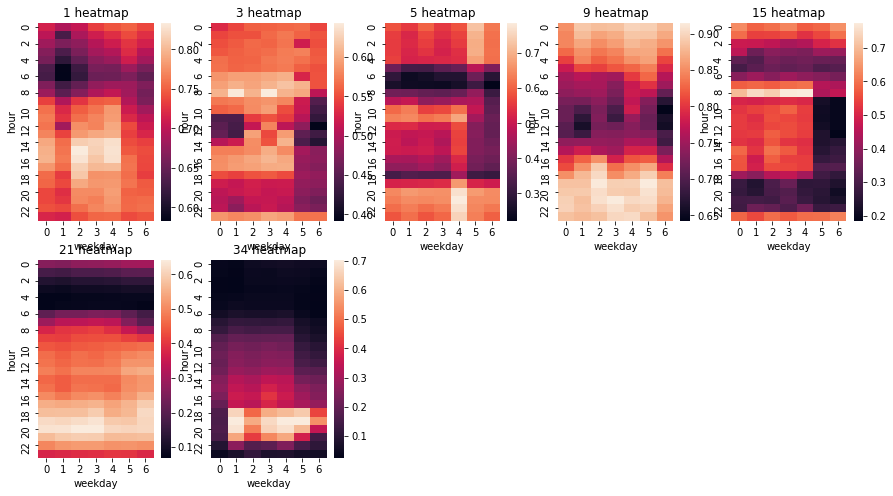

In [159]:
fig = plt.figure(figsize=(15, np.ceil(len(db_99)/5)*4))
for i, n in enumerate(db_99):
    plt.subplot(np.ceil(len(db_99)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

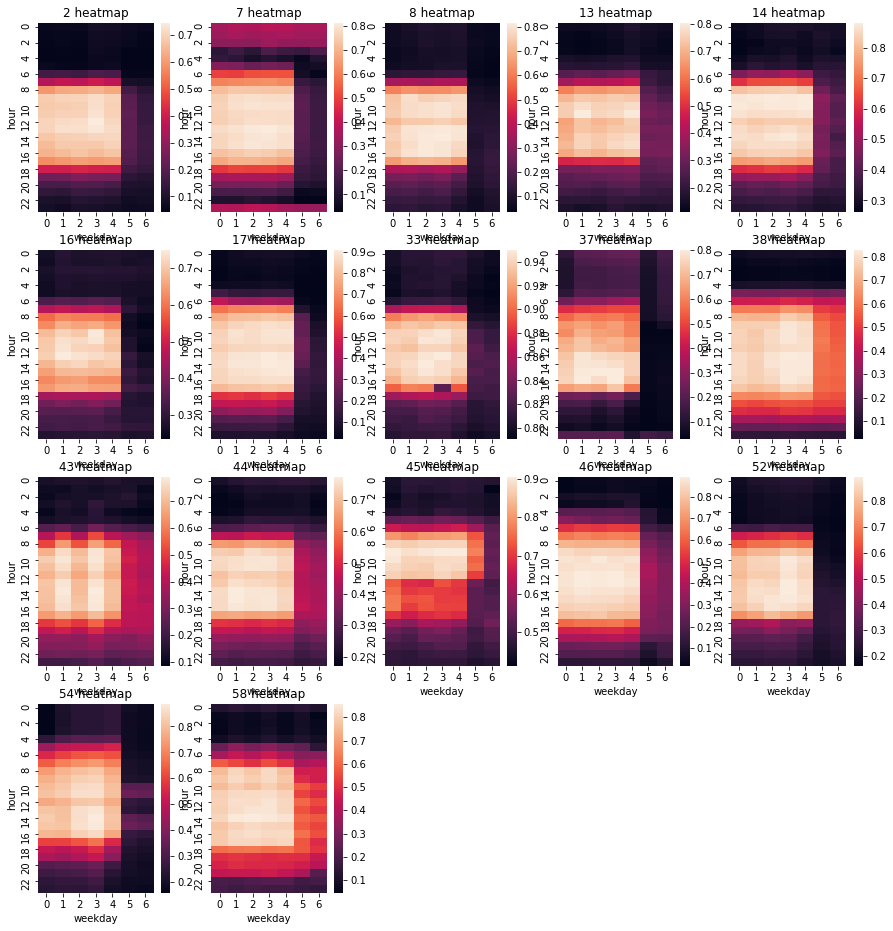

In [160]:
fig = plt.figure(figsize=(15, np.ceil(len(db_0)/5)*4))
for i, n in enumerate(db_0):
    plt.subplot(np.ceil(len(db_0)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

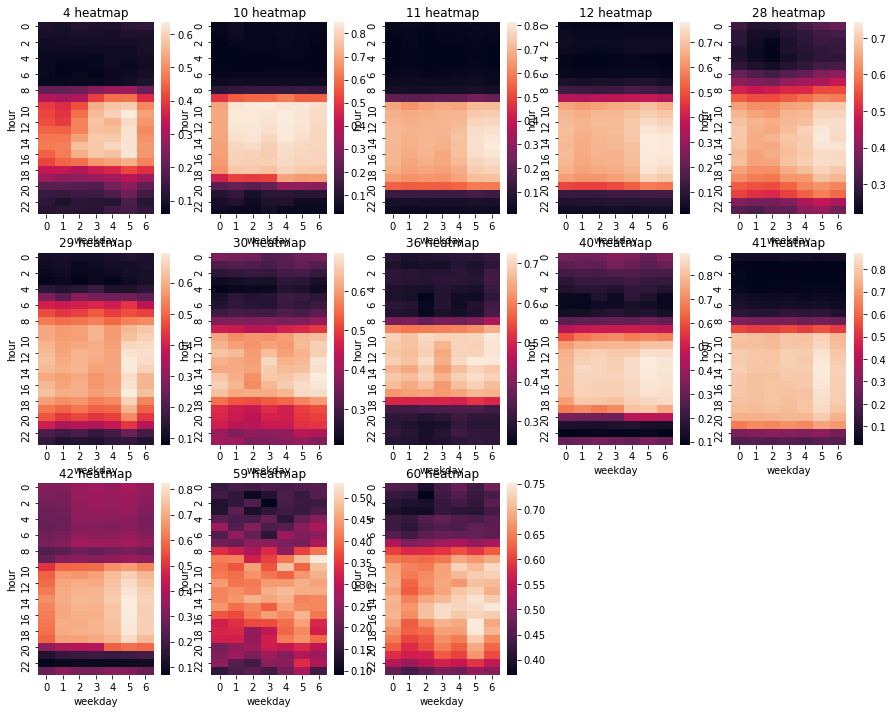

In [161]:
fig = plt.figure(figsize=(15, np.ceil(len(db_1)/5)*4))
for i, n in enumerate(db_1):
    plt.subplot(np.ceil(len(db_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

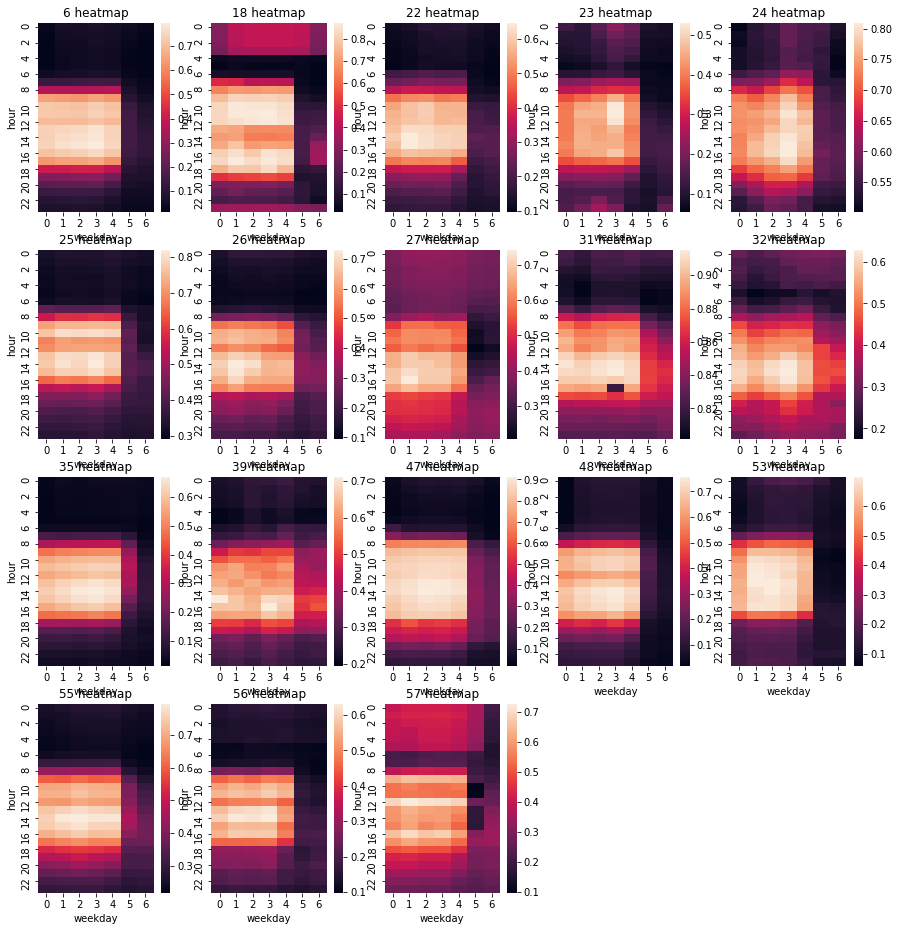

In [162]:
fig = plt.figure(figsize=(15, np.ceil(len(db_2)/5)*4))
for i, n in enumerate(db_2):
    plt.subplot(np.ceil(len(db_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

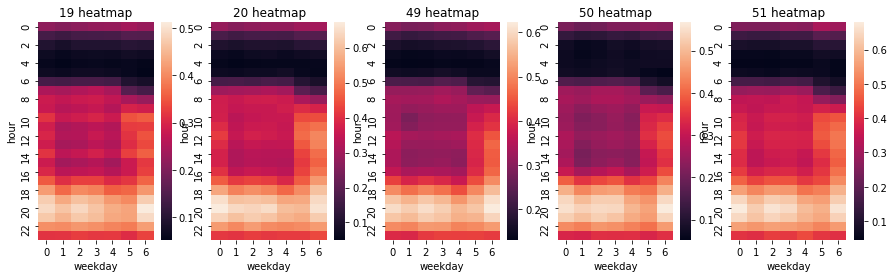

In [163]:
fig = plt.figure(figsize=(15, np.ceil(len(db_3)/5)*4))
for i, n in enumerate(db_3):
    plt.subplot(np.ceil(len(db_3)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

### Linkage

In [232]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

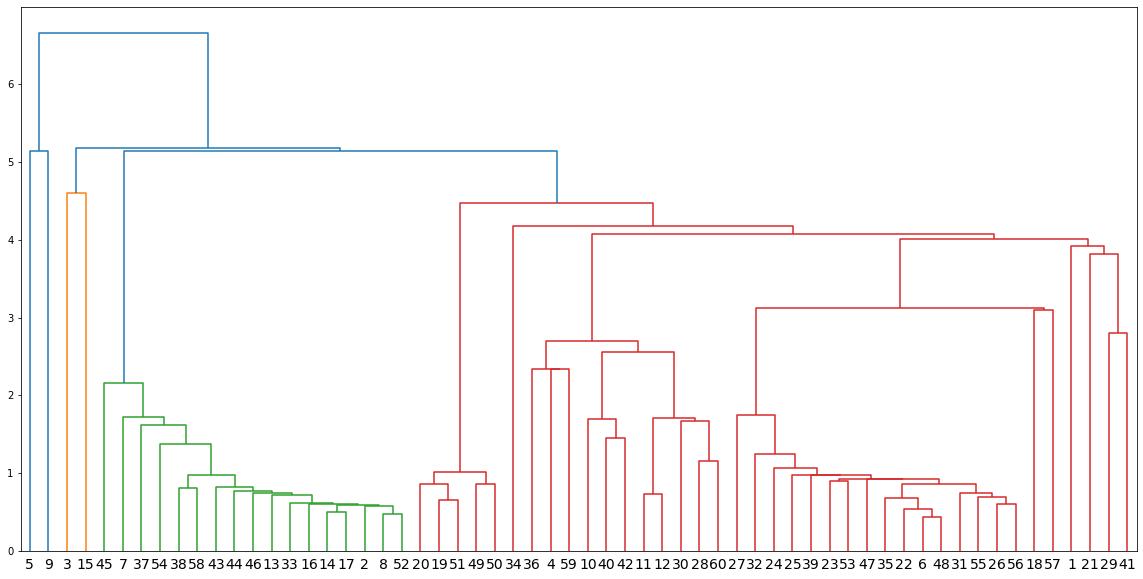

In [233]:
linked = linkage(cl_df.iloc[:, 1:], 'single')

labelList = range(1, 61)

plt.figure(figsize=(20, 10))
dendrogram(linked,
           orientation='top',
           labels=labelList,
           distance_sort='descending',
           show_leaf_counts=True)
plt.xticks(fontsize=14, rotation=0)
plt.show()

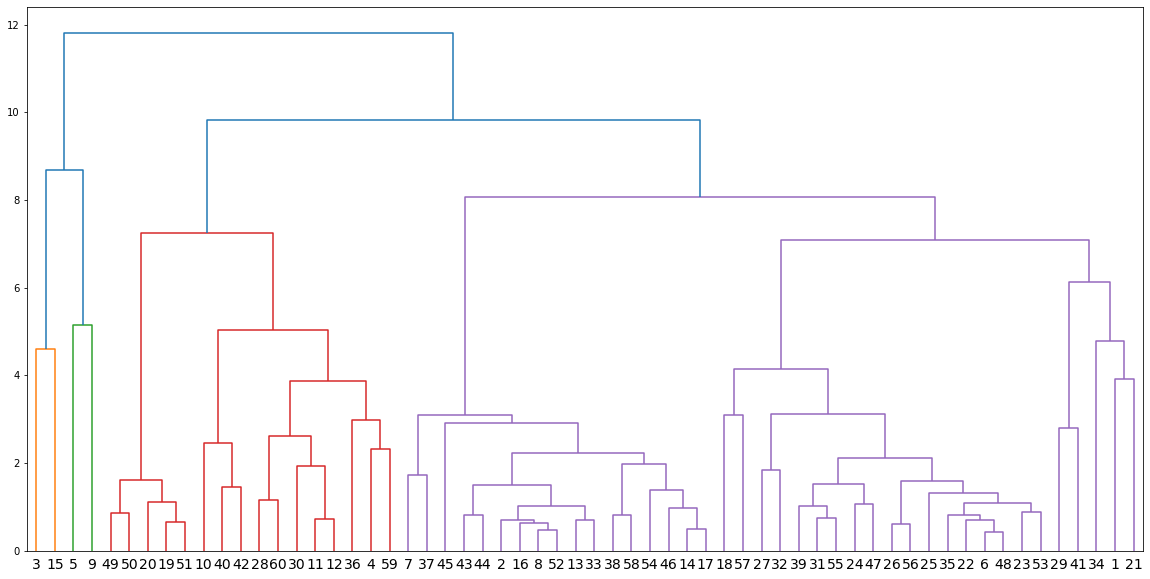

In [234]:
linked = linkage(cl_df.iloc[:, 1:], 'complete')

labelList = range(1, 61)

plt.figure(figsize=(20, 10))
dendrogram(linked,
           orientation='top',
           labels=labelList,
           distance_sort='descending',
           show_leaf_counts=True)
plt.xticks(fontsize=14, rotation=0)
plt.show()

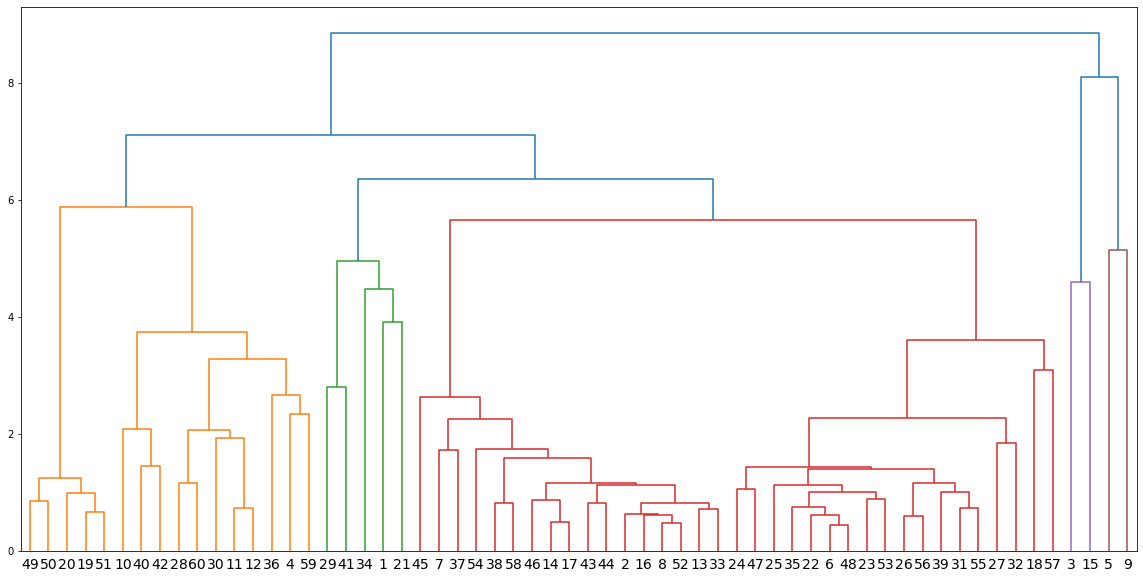

In [235]:
linked = linkage(cl_df.iloc[:, 1:], 'average')

labelList = range(1, 61)

plt.figure(figsize=(20, 10))
dendrogram(linked,
           orientation='top',
           labels=labelList,
           distance_sort='descending',
           show_leaf_counts=True)
plt.xticks(fontsize=14, rotation=0)
plt.show()

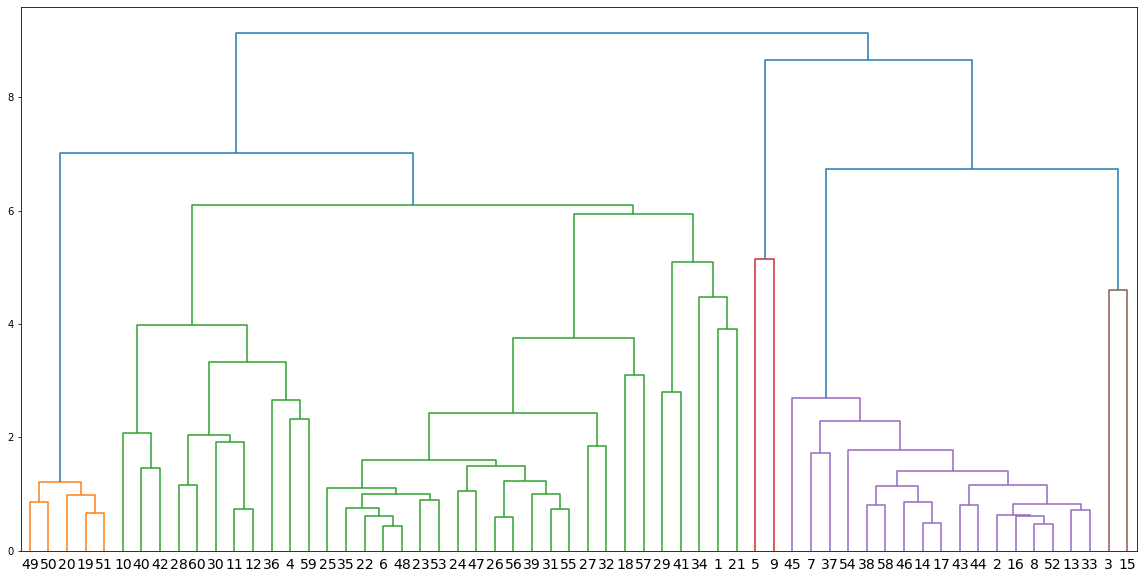

In [236]:
linked = linkage(cl_df.iloc[:, 1:], 'weighted')

labelList = range(1, 61)

plt.figure(figsize=(20, 10))
dendrogram(linked,
           orientation='top',
           labels=labelList,
           distance_sort='descending',
           show_leaf_counts=True)
plt.xticks(fontsize=14, rotation=0)
plt.show()

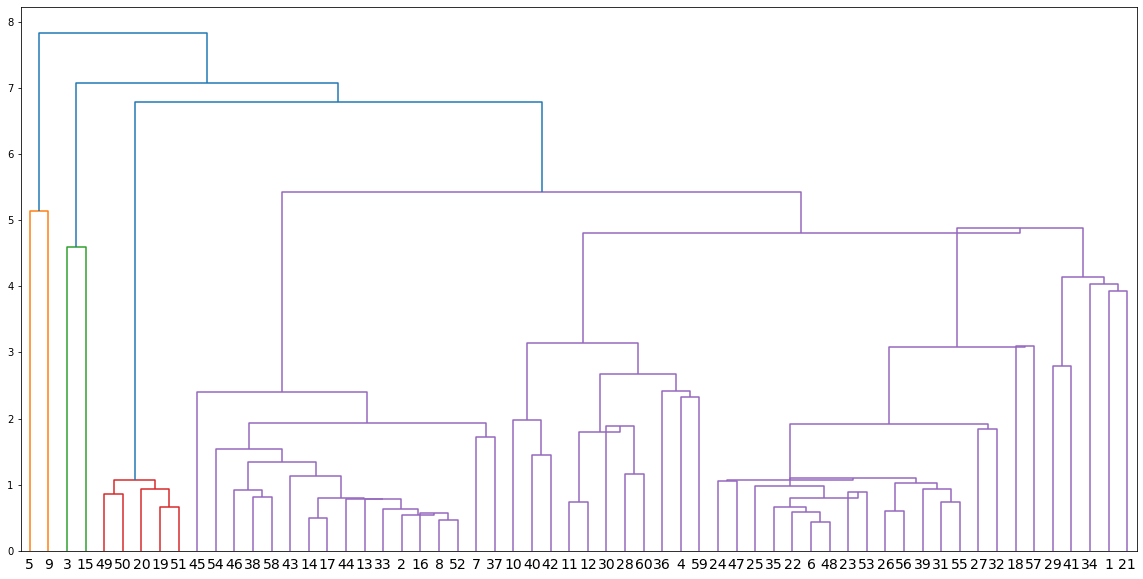

In [237]:
linked = linkage(cl_df.iloc[:, 1:], 'centroid')

labelList = range(1, 61)

plt.figure(figsize=(20, 10))
dendrogram(linked,
           orientation='top',
           labels=labelList,
           distance_sort='descending',
           show_leaf_counts=True)
plt.xticks(fontsize=14, rotation=0)
plt.show()

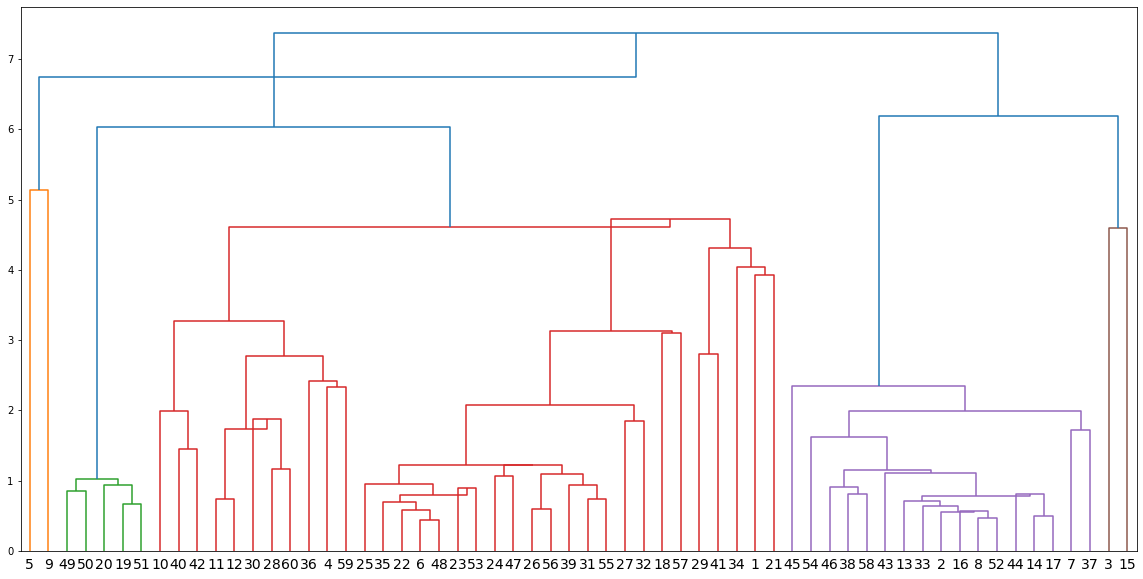

In [238]:
linked = linkage(cl_df.iloc[:, 1:], 'median')

labelList = range(1, 61)

plt.figure(figsize=(20, 10))
dendrogram(linked,
           orientation='top',
           labels=labelList,
           distance_sort='descending',
           show_leaf_counts=True)
plt.xticks(fontsize=14, rotation=0)
plt.show()

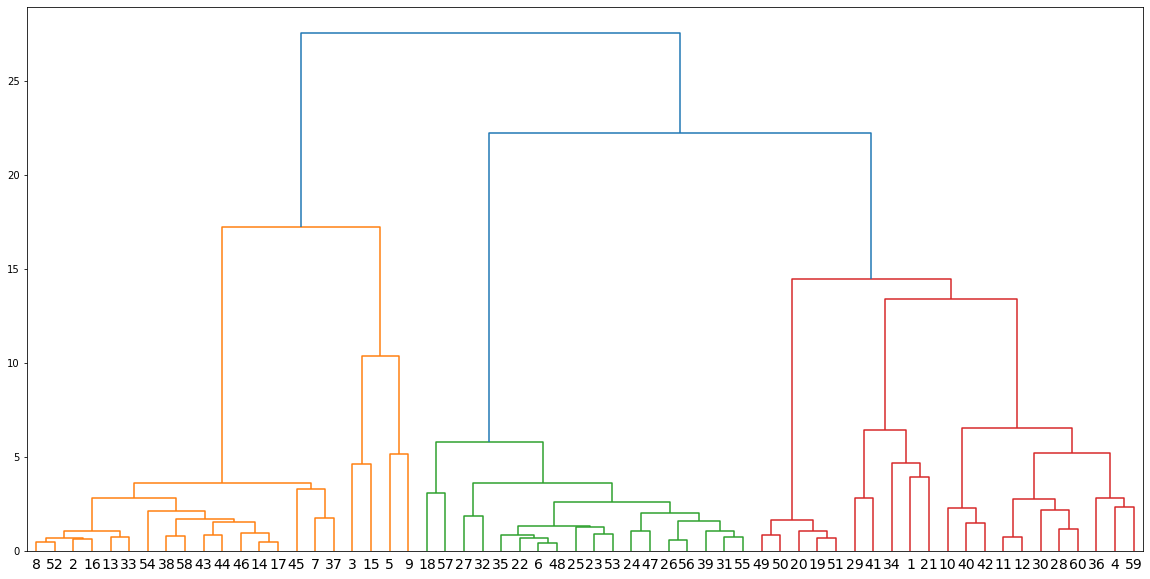

In [239]:
linked = linkage(cl_df.iloc[:, 1:], 'ward')

labelList = range(1, 61)

plt.figure(figsize=(20, 10))
dendrogram(linked,
           orientation='top',
           labels=labelList,
           distance_sort='descending',
           show_leaf_counts=True)
plt.xticks(fontsize=14, rotation=0)
plt.show()